<a href="https://colab.research.google.com/github/M1F1/Text-classification-using-the-semi-supervised-learning-methods/blob/master/SemiSupervisedComposableFrameworkWithMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup env 

In [1]:
from google.colab import drive
from pathlib import Path
import importlib
import pkg_resources

drive.mount('/content/gdrive')

if importlib.util.find_spec('wandb') is None:
  !pip install wandb

!wandb login

if importlib.util.find_spec('neptune') is None:
  !pip install neptune-client


if importlib.util.find_spec('pytorch_lightning') is None:
  !pip install pytorch-lightning

if importlib.util.find_spec('logzero') is None:
  !pip install logzero 

if importlib.util.find_spec('tensorboardX') is None:
  !pip install tensorboardX 

# if importlib.util.find_spec('lineflow') is None:
!pip install lineflow

if importlib.util.find_spec('optuna') is None:
  !pip install optuna

#if importlib.util.find_spec('gdown') is None:
!pip install gdown==3.11.0
  
if importlib.util.find_spec('transformers') is None:
  !pip install transformers 
  
if importlib.util.find_spec('nlpaug') is None:
  !pip install nlpaug 

if importlib.util.find_spec('torchtest') is None:
  !pip install torchtest 

import gdown
import contextlib
import glob
import shutil
import os
from functools import partial
from collections import OrderedDict
from typing import Dict
import re
import yaml
import time
import math
import pprint
import copy
from functools import wraps
from timeit import default_timer as timer
from typing import List, Set, Dict, Tuple, Optional

import lineflow as lf
import lineflow.datasets as lfds

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, RandomSampler, Dataset, sampler, ConcatDataset
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import _LRScheduler, LambdaLR

import sklearn
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import pytorch_lightning as pl
if pkg_resources.parse_version(pl.__version__) < pkg_resources.parse_version("0.7.1"):
  raise RuntimeError("PyTorch Lightning>=0.7.1 is required for this code.")
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import LearningRateLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from gensim.utils import tokenize as gensim_tokenizer
import gensim
from gensim.models.fasttext import FastText as FT_gensim

from transformers import BertModel, BertTokenizer, RobertaTokenizer, RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup 
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import operator
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import toolz
from toolz import partial, compose, juxt, curry, flip, valmap
import optuna
from optuna.integration import PyTorchLightningPruningCallback

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.model.word_stats as nmw
import nlpaug.flow as nafc
from nlpaug.util import Action

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
!pip freeze > requirements.txt

os.environ['PROJECT_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning')
os.environ['EXP_CONF_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'experiment_configurations')
os.environ['DATASETS_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'datasets')
os.environ['REQUIREMENTS_PATH'] = str(Path()/'requirements.txt')
os.environ['MODEL_CHECKPOINT_PATH'] = str(Path()/'model_checkpoints')
os.environ['SPELLING_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'nlpaug'/'spelling_en.txt') 
os.environ['NLPAUG_PATH'] = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'nlpaug')
artefacts_temp_dir = os.path.join(os.environ['PROJECT_PATH'], 'parametrized_nbs')

neptune_api_token_key_file = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'neptune_api_token.txt')
with open (neptune_api_token_key_file, 'r') as f:
  os.environ['NEPTUNE_API_TOKEN'] = f.readlines()[0]

if not os.path.exists(artefacts_temp_dir):
  os.makedirs(artefacts_temp_dir)

if not os.path.exists(os.environ['MODEL_CHECKPOINT_PATH']):
  os.makedirs(os.environ['MODEL_CHECKPOINT_PATH'])

if not os.path.exists(os.environ['EXP_CONF_PATH']):
  os.makedirs(os.environ['EXP_CONF_PATH'])



Mounted at /content/gdrive
     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 102kB 4.9MB/s 
     |████████████████████████████████| 122kB 8.5MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=c4d8a73c3f9b2d89edec4c2822b5c0ce2ad944ac13f418461f85e9cdd8214ac8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=1a2ff89e16b23ba404609bf6b5426a34fa4344ca340e1424172c4a2ff5aa397c
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=423897881d22a9721de58

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
import numpy as np

from keras.layers import Dense, Input, Flatten, Reshape, concatenate, Dropout
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras import optimizers
from keras import regularizers

import sys

def get_model():
    """
    Convolution neural network model for sentence classification.
    Parameters
    ----------
    EMBEDDING_DIM: Dimension of the embedding space.
    MAX_SEQUENCE_LENGTH: Maximum length of the sentence.
    MAX_NB_WORDS: Maximum number of words in the vocabulary.
    embeddings_index: A dict containing words and their embeddings.
    word_index: A dict containing words and their indices.
    labels_index: A dict containing the labels and their indices.
    Returns
    -------
    compiled keras model
    """
    EMBEDDING_DIM = 300
    MAX_SEQUENCE_LENGTH = 600
    print('Preparing embedding matrix.')
    num_words = 45000
    labels_index = [0, 1]
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    

    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)


    print('Training model.')

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    print(embedded_sequences.shape)


    # add first conv filter
    embedded_sequences = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedded_sequences)
    x = Conv2D(100, (5, EMBEDDING_DIM), activation='relu')(embedded_sequences)
    x = MaxPooling2D((MAX_SEQUENCE_LENGTH - 5 + 1, 1))(x)


    # add second conv filter.
    y = Conv2D(100, (4, EMBEDDING_DIM), activation='relu')(embedded_sequences)
    y = MaxPooling2D((MAX_SEQUENCE_LENGTH - 4 + 1, 1))(y)


    # add third conv filter.
    z = Conv2D(100, (3, EMBEDDING_DIM), activation='relu')(embedded_sequences)
    z = MaxPooling2D((MAX_SEQUENCE_LENGTH - 3 + 1, 1))(z)


    # concate the conv layers
    alpha = concatenate([x,y,z])

    # flatted the pooled features.
    alpha = Flatten()(alpha)

    # dropout
    alpha = Dropout(0.5)(alpha)

    # predictions
    preds = Dense(len(labels_index), activation='softmax')(alpha)

    # build model
    model = Model(sequence_input, preds)
    


    return model


In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling2D, Conv2D, Embedding
from keras.layers.merge import Concatenate


def get_model():
    model_type = 'CNN-static'
    embedding_dim = 300
    sequence_length = 600
    filter_sizes = [1,2,3,5]
    num_filters = 32
    vocabulary_inv_num = 45000
    dropout = 0.5



    if model_type == "CNN-static":
        input_shape = (sequence_length, embedding_dim)
    else:
        input_shape = (sequence_length,)

    model_input = Input(shape=input_shape)

    # Static model does not have embedding layer
    if model_type == "CNN-static":
        z = model_input
    else:
        z = Embedding(vocabulary_inv_num, embedding_dim, input_length=sequence_length, name="embedding")(model_input)


    # Convolutional block
    conv_blocks = []
    for sz in filter_sizes:
        conv = Conv2D(num_filters, (sz, embedding_dim), activation='relu')(z)
        # conv = MaxPooling1D(pool_size=2)(conv)
        conv =  MaxPooling2D(pool_size=(sequence_length - sz + 1, 1))(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)
    z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

    z = Dropout(dropout)(z)
    #z = Dense(embedding_dim, activation="relu")(z)
    model_output = Dense(2, activation="softmax")(z)

    model = Model(model_input, model_output)
    return model

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Conv1D, Embedding
from keras.layers.merge import concatenate

def get_model():
    main_input = Input(shape=(300,), dtype='float64')
         # (using pre-trained word vectors)
    embedder = Embedding(45000 + 1, 300, input_length=600, trainable=False)
    embed = embedder(main_input)
         # 3,4,5
    cnn1 = Conv1D(32, 3, padding='same', strides=1, activation='relu')(embed)
    cnn1 = MaxPooling1D(pool_size=300 - 3 + 1)(cnn1)
    cnn2 = Conv1D(32, 4, padding='same', strides=1, activation='relu')(embed)
    cnn2 = MaxPooling1D(pool_size=300 - 4 + 1)(cnn2)
    cnn3 = Conv1D(32, 5, padding='same', strides=1, activation='relu')(embed)
    cnn3 = MaxPooling1D(pool_size=300 - 5 + 1)(cnn3)
         # Combine the output vectors of the three models
    cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.2)(flat)
    main_output = Dense(2, activation='softmax')(drop)
    model = Model(inputs=main_input, outputs=main_output)
    return model


In [25]:
get_model()

### Utils

In [2]:
def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print('Elapsed time: {}'.format(end-start))
        return result
    return wrapper

def compute_global_metric(outputs, metric):
    return sum([out[metric] for out in outputs]) / len(outputs)


def create_metrics_dict(phase_type: str, loss, labels, labels_hat, max_probs) -> dict:

    output_dict = {f'{phase_type}_loss': loss}
    
    metrics_keys = [
                    f'{phase_type}_accuracy_error',
                    f'{phase_type}_f1_error',
                    f'{phase_type}_recall_error',
                    f'{phase_type}_precision_error'
                   ]

    error_map = lambda x: 1-x

    error_metrics_values = juxt(
                                compose(error_map, partial(accuracy_score)),
                                compose(error_map, partial(f1_score, **{'average':'micro'})),
                                compose(error_map, partial(recall_score, **{'average':'micro'})),
                                compose(error_map, partial(precision_score, **{'average':'micro'}))
                               )(labels, labels_hat)


    output_dict.update(dict(zip(metrics_keys, error_metrics_values)))

    confident_keys = [
                      f'{phase_type}_max_confident',
                      f'{phase_type}_min_confident',
                      f'{phase_type}_mean_confident',
                      f'{phase_type}_std_confident'
                     ]
    confident_values = toolz.juxt(
                                  np.max,
                                  np.min, 
                                  np.mean,
                                  np.std,
                                 )(max_probs)

    output_dict.update(dict(zip(confident_keys, confident_values)))

    return output_dict


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def tfidf_tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)


def create_tfidf_model(df: pd.DataFrame):  
  train_data = df['text'] 
  train_x = train_data.values
    
  train_x_tokens = [tfidf_tokenizer(x) for x in train_x]
    
  tfidf_model = nmw.TfIdf()
  tfidf_model.train(train_x_tokens)
  tfidf_model.save(os.environ['NLPAUG_PATH'])
  os.environ['TFIDF_MODEL_PATH']  = os.path.join(os.environ['NLPAUG_PATH'], 'tfidfaug_w2tfidf.txt')
  os.listdir(os.environ['NLPAUG_PATH'])


class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metric)


# credits:
# https://github.com/galatolofederico/pytorch-balanced-batch/blob/master/sampler.py        
#-------------------------------------------------------------------------------
class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)

    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)
#-------------------------------------------------------------------------------


# credits:
# https://github.com/pytorch/pytorch/issues/3223
#-------------------------------------------------------------------------------
def size_splits(tensor, split_sizes, dim=0):
    """Splits the tensor according to chunks of split_sizes.
    
    Arguments:
        tensor (Tensor): tensor to split.
        split_sizes (list(int)): sizes of chunks
        dim (int): dimension along which to split the tensor.
    """
    if dim < 0:
        dim += tensor.dim()
    
    dim_size = tensor.size(dim)
    if dim_size != torch.sum(torch.Tensor(split_sizes)):
        raise KeyError("Sum of split sizes exceeds tensor dim")
    
    splits = torch.cumsum(torch.Tensor([0] + split_sizes), dim=0)[:-1]

    return tuple(tensor.narrow(int(dim), int(start), int(length)) 
        for start, length in zip(splits, split_sizes))
#-------------------------------------------------------------------------------


# credits:
# Modified StepLR from https://pytorch.org/docs/stable/optim.html
#-------------------------------------------------------------------------------
class StepLR(_LRScheduler):
    """Decays the learning rate of each parameter group by gamma every
    step_size epochs. Notice that such decay can happen simultaneously with
    other changes to the learning rate from outside this scheduler. When
    last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.

    Example:
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
        >>> # lr = 0.0005   if 60 <= epoch < 90
        >>> # ...
        >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        >>> for epoch in range(100):
        >>>     train(...)
        >>>     validate(...)
        >>>     scheduler.step()
    """

    def __init__(self, optimizer, step_size, decay_step, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        # adding constant initial learning rate for n decay_step
        self.decay_step = decay_step 
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
            
        if (self.optimizer._step_count < self.decay_step) or (self.last_epoch == 0) or (self.last_epoch % self.step_size != 0):
            return [group['lr'] for group in self.optimizer.param_groups]
            
        return [group['lr'] * self.gamma for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]        
#-------------------------------------------------------------------------------


# credits:
# https://www.kaggle.com/indralin/train-uses-tpu-in-kaggle-kernel-baseline-0-82
#-------------------------------------------------------------------------------
def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        no_progress = float(current_step - num_warmup_steps) / \
            float(max(1, num_training_steps - num_warmup_steps))
        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)
#-------------------------------------------------------------------------------

@curry
def compute_subsample_of_data(dataset_size,
                               procent):
  return dataset_size * procent / 100.

@curry
def compute_procent_of_subsample(dataset_size,
                                  sub_sample_size):
  return sub_sample_size * 100. / dataset_size 

@curry
def get_procents(dataset_size, sub_samples):
  procents = list(map(compute_procent_of_subsample(dataset_size), sub_samples))
  return procents

@curry
def get_subsamples(dataset_size, procents): 
  sub_samples = list(map(compute_subsample_of_data(dataset_size),
                         procents))
  return sub_samples


def show_n_labels_v_sizes(dataset):

  if dataset == 'mr': 
    ds_size = 1800
  elif dataset == 'imdb':
    ds_size = 45000
  elif dataset == 'mnist':
    ds_size = 60000
  else:
    raise ValueError('wrong dataset name')

  val_procents = [5.5, 11., 16.]
  label_procents = [5.5, 27.5, 55]

  l_s, v_s =juxt(flip(get_subsamples)(label_procents),
                 flip(get_subsamples)(val_procents))(ds_size)

  print(f'{dataset} n_labels ', l_s)
  print(f'{dataset} val_sizes ', v_s)
  print()


def get_hyperparameters_from_yaml_file(project_name, init_load=False):

  conf_file_name = project_name + '.yaml'
  conf_file_path =  str(Path(os.environ['EXP_CONF_PATH'])/conf_file_name)
  stream = open(conf_file_path, 'r')
  conf = yaml.load(stream)
  hparams = conf
  if init_load:
    conf.pop('wandb_version', None)
    conf.pop('_wandb', None)
    print('init_load')
    get_value = curry(flip(dict.get))('value')
    hparams = valmap(get_value, conf)
  return hparams


def save_hyperparameters_to_yaml_file(project_name, hparams):

  conf_file_name = project_name + '.yaml'
  conf_file_path =  str(Path(os.environ['EXP_CONF_PATH'])/conf_file_name)
  with open(conf_file_path, 'w') as file:
    yaml.dump(hparams, file)
  print(f'dupmed hparams to {conf_file_path}')


def get_subsamples_sizes(dataset,
                         phase,
                         val_splits_procents=[0.2, 0.3, 0.5],
                         multiplicator=0.333):
  if dataset == 'MR' or dataset == 'IMDB': 
    ds_size = 1800
  # elif dataset == 'IMDB':
  #   ds_size = 45000
  elif dataset == 'MNIST':
    ds_size = 60000
  else:
    raise ValueError('wrong dataset name')

  n_labeled_ss = int(ds_size * multiplicator)
  n_unlabeled_ss = ds_size - n_labeled_ss

  def get_ss(val_split_idx, label_factor, unlabel_factor): 
    labeled_ss = int(n_labeled_ss * label_factor)
    val_ss = int(labeled_ss * val_splits_procents[val_split_idx])
    train_ss = labeled_ss - val_ss
    unlabeled_ss = int(n_unlabeled_ss * unlabel_factor)
    split_ss = [train_ss, val_ss, unlabeled_ss]
    return split_ss

  if phase == 'tuning_0':
    return get_ss(val_split_idx=0,
                  label_factor=multiplicator,
                  unlabel_factor=multiplicator)
    
  elif phase == 'tuning_1':
    return get_ss(val_split_idx=1,
                  label_factor=multiplicator,
                  unlabel_factor=multiplicator)
    
  elif phase == 'tuning_2':

    return get_ss(val_split_idx=2,
                  label_factor=multiplicator,
                  unlabel_factor=multiplicator)

  elif phase == 'run':  

    return get_ss(val_split_idx=0,
                  label_factor=multiplicator,
                  unlabel_factor=multiplicator)
  
  elif phase == 'run_labeled_unlabeled_addition_1':  

    return get_ss(val_split_idx=0,
                  label_factor=2 * multiplicator,
                  unlabel_factor=2 * multiplicator)

  elif phase == 'run_labeled_unlabeled_addition_2':  

    return get_ss(val_split_idx=0,
                  label_factor=1,
                  unlabel_factor=1)

  elif phase == 'run_unlabeled_addition_1':  

    return get_ss(val_split_idx=0,
                  label_factor=multiplicator,
                  unlabel_factor=2 * multiplicator)

  elif phase == 'run_unlabeled_addition_2':  

    return get_ss(val_split_idx=0,
                  label_factor=multiplicator,
                  unlabel_factor=1)
  else:
    raise ValueError('wrong phase name')


def get_experiment_scores_on_test(dataset,
                       methods,
                       val_sizes,
                       phases):

  
  for method in tqdm(methods):
    print('method: ', method)
    print('----------------------------------------------------------------')
    for val_size in tqdm(val_sizes):
      print('val_size: ', val_size)
      print('--------------------------------------------------------------')
      hparams_file = f'{method}_{dataset}_v{val_size}'
      hparams = get_hyperparameters_from_yaml_file(hparams_file, init_load=True)
      print('load_hparams from: ', hparams_file)
      for phase in tqdm(phases):
        print('phase: ', phase)
        print('------------------------------------------------------------')
        change_hparams_dict = dict()
        change_hparams_dict['dont_change_anything'] = True
        change_hparams_dict['epoch_over_higher_ratio'] = True
        change_hparams_dict['model_val_size'] = val_size
        run_phase_of_experiment(
                                training_method=training_method,
                                dataset_name=dataset,
                                phase=phase, hparams=hparams,
                                train_df=train_df, test_df=test_df,
                                change_hparams_dict=change_hparams_dict,
                                disable_testing=False,
                                disable_validation=True,
                                )
        print('end phase: ', phase)
        print('------------------------------------------------------------')

      print('end val_size: ', val_size)
      print('--------------------------------------------------------------')
  
    print('end method: ', method)
    print('--------------------------------------------------------------')


def run_phase_of_experiment(
                            training_method,
                            dataset_name,
                            phase,
                            hparams,
                            train_df,
                            test_df,
                            change_hparams_dict,
                            disable_testing,
                            disable_validation,
                            number_of_runs=3,
                            ):
  
  # hparams = get_hyperparameters_from_yaml_file(project_name, init_load=False)

  t, v, unl = get_subsamples_sizes(dataset=dataset_name, phase=phase)
  hparams['train_l_size'] = t
  hparams['val_size'] = v
  hparams['train_unl_size'] = unl
  hparams['phase'] = phase 
  if disable_validation:
    new_project_name = f'{dataset_name}_v{0}'
  else:
    new_project_name = f'{training_method}_{dataset_name}_v{v}'
  hparams['project_name'] = new_project_name

  if change_hparams_dict is not None:
    for key, value in change_hparams_dict.items():
      hparams[key] = value

  for i in range(number_of_runs):
    hparams['seed'] = i
    run_experiment(hparams,
                   train_df=train_df, test_df=test_df,
                   disable_testing=disable_testing,
                   disable_validation=disable_validation)

  # save_hyperparameters_to_yaml_file(new_project_name, hparams)
  return new_project_name


def run_experiment(hparams, train_df=None, test_df=None,
                   disable_testing=False, disable_validation=False):
  
  set_seed(hparams['seed'])
  experiment_name = hparams['dataset'] + \
                    "-" + hparams['model_arch'] + \
                    "-" + hparams['training_method'] + \
                    "-" + str(hparams['val_size'])

  hparams['disable_validation'] = disable_validation 
  hparams['disable_testing'] = disable_testing
  tags = []
  tags.append(hparams['dataset'])
  tags.append(hparams['trail'])
  tags.append(hparams['model_arch'])
  tags.append(hparams['training_method'])
  tags.append(str(hparams['val_size']))
  tags.append(str(hparams['train_l_size']))
  tags.append(str(hparams['train_unl_size']))

  # logers
  # neptune_logger = NeptuneLogger(
  #                                project_name="m1f1/lightning-exps-text,
  #                                close_after_fit=False,
  #                                experiment_name=experiment_name,  # Optional,
  #                                params=hparams, # Optional,
  #                                tags=tags # Optional,
  #                               )
  
  wandb_logger = WandbLogger(project=hparams['project_name'],
                             name=experiment_name,
                             tags=tags)
  wandb_logger.log_hyperparams(hparams)
  
  
  # callbacks:
  # early_stop_callback = EarlyStopping(
  #                         monitor="val_loss",
  #                         min_delta=0.0,
  #                         patience=hparams['patience'],
  #                         verbose=True,
  #                         mode='min'
  #                       )
  lr_logger = LearningRateLogger()

  [print(f'{k}: {v}') for k, v in hparams.items()]
  
  if hparams['save_best_model']:
    checkpoint_path = os.path.join(os.environ['MODEL_CHECKPOINT_PATH'], '{epoch}-{val_accuracy_error:.2f}')
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                          mode='min',
                                          monitor='val_accuracy_error',
                                          save_top_k=1)
  else:
    checkpoint_callback = None

  if disable_validation:
    limit_val_batches = 0 
  else:
    limit_val_batches = 1.

  # training and evaluating model
  trainer = pl.Trainer(
                  gpus=1,
                  # logger=neptune_logger,
                  logger=wandb_logger,
                  checkpoint_callback=checkpoint_callback,
                  # early_stop_callback=early_stop_callback,
                  # val_check_interval=hparams['val_check_interval'],
                  # distributed_backend=hparams['distributed_backend'],
                  # default_root_dir="./test_run_logs",
                  callbacks=[lr_logger],
                  fast_dev_run=hparams['test_run'],
                  # train_percent_check=0.001,
                  limit_val_batches=limit_val_batches,
                  # min_epochs=hparams['min_epochs'],
                  max_steps =hparams['max_steps'],
            )
  
  model = ComposableFramework(hparams, train_df=train_df, test_df=test_df)
  
  wandb_logger.watch(model, log='all', log_freq=10)
  
  trainer.fit(model)
  if hparams['disable_testing'] == True:
    print('Training done')
  else:
    if hparams['disable_validation']:
      trainer.test(model)

    elif hparams['save_best_model']:
      model_loaded= ComposableFramework.load_from_checkpoint(checkpoint_callback.best_model_path)
      trainer.test(model)
    else:
      trainer.test(model)




## Data Manipulation

### Preprocessing whole dataset 

In [3]:
# credits:
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
#-------------------------------------------------------------------------------
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x
#-------------------------------------------------------------------------------

def get_ft_vectors():
    source ='./cc.en.300.vec' 
    my_file = Path(source)
    if not my_file.is_file():
      !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
      !gunzip -k cc.en.300.vec.gz

    def get_coefs(word,*arr):
       return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(source) if len(o)>100)

    return embeddings_index


def create_ft_embeder():
  source ='./cc.en.300.bin' 
  my_file = Path(source)
  if not my_file.is_file():
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
    !gunzip -k cc.en.300.bin.gz

  print('Loading fastText model into memory, it can take a while...')
  start = time.time()
  ft = gensim.models.FastText.load_fasttext_format("./cc.en.300.bin")
  end = time.time()
  duration =  end - start
  print(f'Loading took: {duration} s')

  return ft
  

def create_spacy_nlp_embeder():

  my_file = Path("./cc.en.300.vec")
  if not my_file.is_file():
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

  my_file2 = Path("./en_vectors_wiki_lg")
  if not my_file2.is_file():
    !python -m spacy init-model en /en_vectors_wiki_lg --vectors-loc cc.en.300.vec.gz
    
  print('Loading fastText vectors into spaCy model into memory, it can take a while...')
  start = time.time()
  nlp = spacy.load("/en_vectors_wiki_lg")
  end = time.time()
  duration =  end - start
  print(f'Loading took: {duration} s')
  
  return nlp 


# credits:
# https://www.kaggle.com/gmhost/gru-capsule
#-------------------------------------------------------------------------------

def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'

    def get_coefs(word,*arr):
       return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
           continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector

    return embedding_matrix
#-------------------------------------------------------------------------------

def correct_abbrevation_and_mispelling(text: str) -> str: 
  # credits
  # https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing
  mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
  mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
  return mispell_re.sub(lambda match: mispell_dict[match.group(0)], text)


@curry 
def remove_stopwords(stopwords: [str], sentence: str) -> str:
  words = word_tokenize(sentence)
  return " ".join([word for word in words if not word in stopwords])


@curry
def delete_stopwords_with_regex(stopwords: [str], text: str) -> str:
  pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
  return pattern.sub('', text)


def create_stopwords_set(stopwords=None, show_classification=False) -> Set[str]:
  if stopwords == None:
    # credits:
    # https://gist.github.com/sebleier/554280
    stopwords = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
  
  sid = SentimentIntensityAnalyzer()
  pos_word_list=[]
  neu_word_list=[]
  neg_word_list=[]
  
  for word in stopwords:
      if (sid.polarity_scores(word)['compound']) >= 0.2:
          pos_word_list.append(word)
      elif (sid.polarity_scores(word)['compound']) <= -0.2:
          neg_word_list.append(word)
      else:
          neu_word_list.append(word)                
  if show_classification: 
    print('Positive :',pos_word_list)        
    print('Neutral :',neu_word_list)    
    print('Negative :',neg_word_list)  
  
  return set(stopwords) - set(pos_word_list + neg_word_list)

    
def create_dataset_preprocessor() -> str:
  stopwords = create_stopwords_set()

  remove_html_tags_re = re.compile(r'<.*?>')
  remove_punctuation_re = re.compile(r'[^\w\s]+')
  remove_extra_whitespaces_re = re.compile(r' +')
  remove_numeric_re = re.compile(r'\d+')
  
  remove_html_tags = curry(remove_html_tags_re.sub)('') 
  remove_punctuation = curry(remove_punctuation_re.sub)('') 
  remove_extra_whitespaces = curry(remove_extra_whitespaces_re.sub)(' ') 
  remove_numeric = curry(remove_numeric_re.sub)('') 

  preprocessing = compose(
                          remove_stopwords(stopwords),
                          remove_extra_whitespaces,
                          remove_punctuation,
                          remove_html_tags,
                          correct_abbrevation_and_mispelling,
                          remove_numeric,
                          str.lower
                        )
  
  return preprocessing


def compute_embeddings_mean_and_std(embeddings_file="./cc.en.300.vec"):    
    def get_coefs(word,*arr):
       return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(embeddings_file) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    return emb_mean, emb_std


@timing
def initial_preprocessing_lineflow(ds_path):
  not_none = lambda x: x["text"] is not None 
  initial_dataset_preprocessor = create_dataset_preprocessor()
  preprocess = lambda x: {
                          'text': initial_dataset_preprocessor(x['text']),
                          'label': x['label'],
                          'paraphrases': initial_dataset_preprocessor(x['paraphrases']),
                          }
  ds = lf.CsvDataset(ds_path, header=True).filter(not_none).map(preprocess)

  train, test = lf.cross_validation.split_dataset_random(ds,
                int(len(ds) * 0.9),
                seed=1)
  # train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
  
  return np.array(train), np.array(test)

@timing
def initial_preprocessing_pandas(ds_path, hparams):
  initial_dataset_preprocessor = create_dataset_preprocessor()
  df = pd.read_csv(dataset_path)
  df = df.loc[df['text'] != None]
  df['text'] = df['text'].apply(initial_dataset_preprocessor)
  df['parahprases'] = df['paraphrases'].apply(initial_dataset_preprocessor)
  train, test = train_test_split(df, test_size=hparams['train_test_split'])
  
  return train, test 

### Datasets EDA

#### IMDB

In [ ]:
# train = lfds.Imdb('train')
# test = lfds.Imdb('test')
# dataset = train + test
# ds = dataset.map(lambda x: {'text': x[0], 'label':x[1], 'tokens_len': len(list(gensim_tokenizer(x[0])))})
# df = pd.DataFrame(ds)
# df['tokens_len'].describe()

#### MR

In [ ]:
# dataset_path = str(Path()/
#                         'gdrive'/
#                         'My Drive'/
#                         'praca_magisterska'/
#                         'pytorch_lightning'/
#                         'datasets'/
#                         'mr_with_bt2.csv')
# df = pd.read_csv(dataset_path, index_col=None)
# df['totalwords'] = df['text'].str.split().str.len()
# print(df['totalwords'].describe())

# dataset_preprocessor = create_dataset_preprocessor()

# start = timer()
# df['text'] = df['text'].apply(dataset_preprocessor)
# end = timer()
# print('time: ', end - start)

# df['totalwords'] = df['text'].str.split().str.len()
# print(df['totalwords'].describe(percentiles=[.25, .5, .75, .90, .95, .98, .99]))

# sentences = df["text"].progress_apply(lambda x: x.split()).values
# vocab = build_vocab(sentences)
# print(len(vocab))
# # oov = check_coverage(vocab, embedder)
# # oov

In [ ]:
# hparams = {'maxlen': 600,
#            'max_features': 120000,
#            'embed_size': 300,
#            'emb_mean': 0.001960038,
#            'emb_std': 0.0732493}

# emb_mean, emb_std = hparams['emb_mean'], hparams['emb_std']

# # split data into train and test dataset 
# train_all = df['text'].values
# # use tokenizer in the same way as label_encoder in data pipelines

# # create tokenizer
# tokenizer = Tokenizer(num_words=hparams['max_features'],
#                       oov_token='######')
# tokenizer.fit_on_texts(list(train_all))

# vocab_prepro = create_vocab_embeddings_preprocessor(tokenizer, hparams)
# t = torch.from_numpy(vocab_prepro('ala ma kota'))

# # create embeddings matrix
# embedding_matrix = create_embeddings_matrix(tokenizer.word_index,
#                                             embedder,
#                                             hparams)

In [ ]:
# class CNN_Text(nn.Module):
#   def __init__(self):
#       super(CNN_Text, self).__init__()
#       filter_sizes = [1,2,3,5]
#       num_filters = hparams['num_filters']#36
#       self.embedding = nn.Embedding(max_features, embed_size)
#       self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
#       self.embedding.weight.requires_grad = False
#       self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
#       self.dropout = nn.Dropout(hparams['dropout'])
#       self.fc1 = nn.Linear(len(filter_sizes)*num_filters, 1)
  
  
#   def forward(self, x):
#       x = self.embedding(x)  
#       x = x.unsqueeze(1)  
#       x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
#       x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
#       x = torch.cat(x, 1)
#       x = self.dropout(x)  
#       logit = self.fc1(x)  
#       return logit

# # keras model 
# def create_embedding_model(vocab_size, max_length):
#     model=models.Sequential()
#     model.add(layers.Embedding(vocab_size, 100, input_length=max_length))
#     model.add(layers.Conv1D(32, 8, activation="relu"))
#     model.add(layers.MaxPooling1D(2))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(10, activation="relu"))
#     model.add(layers.Dense(1,  activation="sigmoid"))   
#     return model

#### NLUHD

In [ ]:
# datasets_path = str(Path()/'gdrive'/'My Drive'/'praca_magisterska'/'pytorch_lightning'/'datasets')
# NLU_HD_path = os.path.join(datasets_path,'NLU-Data-Home-Domain-Annotated-All.csv')
# print(NLU_HD_path)
# # df = pd.read_csv(str(NLU_HD_path), delimiter=';')[['intent', 'answer_annotation']]
# df = pd.read_csv(str(NLU_HD_path), delimiter=';')[['intent', 'answer_annotation', 'scenario']]
# df['intent'] = df[['scenario', 'intent']].agg('-'.join, axis=1) 
# del df['scenario']
# df = df[df['answer_annotation'].notna()]
# df = df.rename(columns={"answer_annotation": "text"})
# nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

# df['text'] = df['text'].apply(normalize,
#                               lowercase=True,
#                               remove_stopwords=False,
#                               with_ner_tags=False,
#                               nlp=nlp) 
# # df.to_csv(os.path.join(datasets_path,'NLU-Data-Home-Domain-preprocessed-without-ner_no-scenario.csv'))
# df.to_csv(os.path.join(datasets_path,'NLU-Data-Home-Domain-preprocessed-without-ner.csv'))
# df['intent'].value_counts().plot(kind="bar", figsize= (21,20))

### FixMatch Augmentations

#### FixMatch Image Augmentation

In [4]:
# credits: 
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py

#-------------------------------------------------------------------------------
import logging
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    # color = (127, 127, 127)
    color = (255)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
            
    return augs
    

#-------------------------------------------------------------------------------
class RandAugmentMCStrong(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, 16)
        return img

class RandAugmentMCWeak(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        return img

        
class TransformFixImage(object):
    def __init__(self, mean, std, n_strong, m_strong, n_weak, m_weak):
        self.weak = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(size=28,
            #                       padding=int(28*0.125),
            #                       padding_mode='reflect')
            RandAugmentMCWeak(n=n_weak, m=m_weak)
            ])
        self.strong = transforms.Compose([
            transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomCrop(size=28,
            #                       padding=int(28*0.125),
            #                       padding_mode='reflect'),
            RandAugmentMCStrong(n=n_strong, m=m_strong)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)


#### FixMatch Text Augmentation

In [5]:
# ---------------------------------------------    
# augmentations on char level 
# ---------------------------------------------    
def print_augmentations(func, text):
  def wrapper():
    print("Augmentation function: ", func.__name__)
    print("Original: ")
    print(text)
    augmented_text = func(text)
    print("Augmention result: ")
    print(augmented_text)
    return augmented_text

  return wrapper() 

def substitute_character_by_keyboard_distance(text):
  aug = nac.KeyboardAug()
  augmented_text = aug.augment(text)
  return augmented_text

def insert_character_randomly(text):
  aug = nac.RandomCharAug(action="insert")
  augmented_text = aug.augment(text)
  return augmented_text 


def substitute_character_randomly(text):
  aug = nac.RandomCharAug(action="substitute")
  augmented_text = aug.augment(text)
  return augmented_text 


def delete_char_randomly(text):
  aug = nac.RandomCharAug(action="delete")
  augmented_text = aug.augment(text)
  return augmented_text 


def swap_character_randomly(text):
  aug = nac.RandomCharAug(action="swap")
  augmented_text = aug.augment(text)
  return augmented_text

# ---------------------------------------------    
# augmentations on word level 
# ---------------------------------------------    
# models - spelling_en.txt
# model_dir with fasttext or word2vec or glove 
# model dir with tf-idf

# that augmentation consume to much RAM

# def insert_word_randomly_by_word_embeddings_similarity(text):
#   # model_type: word2vec, glove or fasttext
#   aug = naw.WordEmbsAug(
#       model_type='word2vec', model_path=os.environ('WORD2VEC_MODEL_PATH'),
#       action="insert")
#   augmented_text = aug.augment(text)
#   print("Original:")
#   print(text)
#   print("Augmented Text:")
#   print(augmented_text)
#   return augmented_text


def insert_word_by_tf_idf_similarity(text):
  aug = naw.TfIdfAug(
      model_path=os.environ['NLPAUG_PATH'],
      action="insert")
  augmented_text = aug.augment(text)
  return augmented_text 



def split_word_to_two_tokens_randomly(text):
  aug = naw.SplitAug()
  augmented_text = aug.augment(text)
  return augmented_text 


def swap_word_randomly(text):
  aug = naw.RandomWordAug(action="swap")
  augmented_text = aug.augment(text)
  return augmented_text 


def substitute_word_by_antonym(text):
  aug = naw.AntonymAug()
  augmented_text = aug.augment(text)
  return augmented_text 


def substitute_word_by_spelling_mistake_words_dictionary(text):
  aug = naw.SpellingAug(os.environ['SPELLING_PATH'])
  augmented_text = aug.augment(text, n=1)
  return augmented_text 

# to slow

# def insert_word_by_contextual_word_embeddings(text):
#   aug = naw.ContextualWordEmbsAug(
#       model_path='bert-base-uncased', action="insert")
#   augmented_text = aug.augment(text)
#   return augmented_text


# def subtitute_word_by_contextual_word_embeddings(text):
#   aug = naw.ContextualWordEmbsAug(
#            model_path='bert-base-uncased', action="substitute")
#   augmented_text = aug.augment(text)
#   return augmented_text


def substitute_word_by_WordNets_synonym(text):
  aug = naw.SynonymAug(aug_src='wordnet')
  augmented_text = aug.augment(text)
  return augmented_text
  
def fixmatch_weak_augment_pool():
    augs = [
            substitute_character_by_keyboard_distance,
            insert_character_randomly,
            substitute_character_randomly,
            delete_char_randomly,
            swap_character_randomly,
            # insert_word_randomly_by_word_embeddings_similarity,
            insert_word_by_tf_idf_similarity,
            split_word_to_two_tokens_randomly,
            swap_word_randomly,
            substitute_word_by_antonym,
            substitute_word_by_spelling_mistake_words_dictionary,
            # insert_word_by_contextual_word_embeddings,
            # subtitute_word_by_contextual_word_embeddings,
            substitute_word_by_WordNets_synonym,
           ]

    return augs

# def fixmatch_strong_augment_pool():
#     augs = [
#             insert_word_by_contextual_word_embeddings,
#             subtitute_word_by_contextual_word_embeddings,
#             substitute_word_by_WordNets_synonym,
#            ]

#     return augs


class WeakRandAugment(object):
  def __init__(self, n, show=False):
    """
    Parameters:
    n (int): number of operations

    """
    assert n >= 0
    self.n = n
    self.augment_pool = fixmatch_weak_augment_pool()
    self.show=show

  def __call__(self, text):
    if self.n <= 0:
      return text
    ops = random.choices(self.augment_pool, k=self.n)
    for op in ops:
        if random.random() < 1.:
          if self.show:
            text = print_augmentations(op, text)
          else:
            text = op(text)
    return text 

# not necessery
# class StrongRandAugment(object):
#   def __init__(self, n, show=False):
#     assert n >= 1
#     self.n = n
#     self.augment_pool = fixmatch_strong_augment_pool()
#     self.show= show

#   def __call__(self, text):
#     ops = random.choices(self.augment_pool, k=self.n)
#     for op in ops:
#       if random.random() < 1.:
#         if self.show:
#           text = print_augmentations(op, text)
#         else:
#           text = op(text)
#     return text 


class TransformFix(object):
  def __init__(self, n_weak=3, show=False):
  # def __init__(self, n_weak=3, n_strong=2, show=False):
    self.weak = WeakRandAugment(n=n_weak, show=show) 
    # self.strong = StrongRandAugment(n=n_strong, show=show)

  def __call__(self, x):
    weak = self.weak(x)
    # strong = self.strong(x)
    return weak #, strong



In [75]:

            # substitute_character_by_keyboard_distance,
            # insert_character_randomly,
            # substitute_character_randomly,
            # delete_char_randomly,
            # swap_character_randomly,
            # insert_word_by_tf_idf_similarity,
            # split_word_to_two_tokens_randomly,
            # swap_word_randomly,
            # substitute_word_by_antonym,
            # substitute_word_by_spelling_mistake_words_dictionary,
            # substitute_word_by_WordNets_synonym,

original = "Basically there is a family where a little boy (Jake) thinks there is a zombie in his dark closet"
weak_augment_pool = fixmatch_weak_augment_pool()

substitute_character_by_keyboard_distance = weak_augment_pool[0]
insert_character_randomly =  weak_augment_pool[1]
substitute_character_randomly = weak_augment_pool[2]
delete_char_randomly = weak_augment_pool[3]
swap_character_randomly = weak_augment_pool[4]
insert_word_by_tf_idf_similarity = weak_augment_pool[5]
split_word_to_two_tokens_randomly = weak_augment_pool[6]
swap_word_randomly = weak_augment_pool[7]
substitute_word_by_antonym = weak_augment_pool[8]
substitute_word_by_spelling_mistake_words_dictionary = weak_augment_pool[9]
substitute_word_by_WordNets_synonym = weak_augment_pool[10]
print('original')
print(original)
print()
for augmentation in weak_augment_pool:
  print(augmentation.__name__)
  print(augmentation(original))
  print()

original
Basically there is a family where a little boy (Jake) thinks there is a zombie in his dark closet

substitute_character_by_keyboard_distance
Basically ttere is a family where a >ittle boy (Jake) tUinks there is a zombie in his dark closet

insert_character_randomly
Basically ther_e is a family whecre a lEittle boy (Jaxke) thinkrs 6there is a zombie in his dark closet

substitute_character_randomly
Basically ther@ is a family where a l%ttle boy (Jake) thinks there is a zombie in his Tark clNset

delete_char_randomly
Basically there is a family where a little boy (Jake) think there is a zomie in his dark clset

swap_character_randomly
Bascialyl there is a famiyl where a little boy (Jake) thikns there is a zombie in his dark closet

insert_word_by_tf_idf_similarity
Identified basically there is a family where apologize a little sayles boy (crib Jake) thinks there cashier is a barenboim zombie in his dark closet

split_word_to_two_tokens_randomly
Basic ally there is a fam ily wher

### Datasets Classes

In [6]:
# !!!!!!!
# TODO: change data_dict keys        
class SimpleDataset(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        # special dict convention for f: process_NLUHD 
        data_dict = {'text': self.x[index],
                     'label': self.y[index]}
        if self.transform is not None:
          return self.transform(data_dict)
        return tuple(data_dict.values()) 

    def __len__(self):
        return len(self.x)
        

class FixMatchAugmentedImageDataset(Dataset):

    def __init__(self, x, y,
                 model_preprocessing = None,
                 fix_match_augmentation = None,
                 show=False):
        self.x = x
        self.y = y
        self.model_preprocessing = model_preprocessing
        self.fix_match_augmentation = fix_match_augmentation
        self.show = show

    def __getitem__(self, index):
        if self.fix_match_augmentation is not None:
          weak_augmented, strong_augmented = \
           self.fix_match_augmentation(self.x[index]) 
          if self.show:
            print_image_augmentations(lambda x: x, self.x[index])
            print_image_augmentations(lambda x: x, weak_augmented)
            print_image_augmentations(lambda x: x, strong_augmented)
        
        weak_aug_data_dict = {'text': weak_augmented,
                              'label': self.y[index]}

        strong_aug_data_dict = {'text': strong_augmented,
                                'label': self.y[index]}

        if self.model_preprocessing is not None:
          return self.model_preprocessing(weak_aug_data_dict), self.model_preprocessing(strong_aug_data_dict)

        return tuple(weak_aug_data_dict.values()), tuple(strong_aug_data_dict.values()) 

    def __len__(self):
        return len(self.x)


class FixMatchAugmentedTextDataset(Dataset):

    def __init__(self, x, x_paraphrases, y,
                 model_preprocessing = None,
                 fix_match_augmentation = None, show=False, aug_type='WS'):
        self.x = x
        self.x_paraphrases = x_paraphrases
        self.y = y
        self.model_preprocessing = model_preprocessing
        self.fix_match_augmentation = fix_match_augmentation
        self.show = show
        self.aug_type = aug_type

    def __getitem__(self, index):
        if self.fix_match_augmentation is not None:
          if self.aug_type == 'WS':
            weak_augmented, strong_augmented = \
            self.fix_match_augmentation(self.x[index]), self.x_paraphrases[index] 
          elif self.aug_type == 'NS':
            weak_augmented, strong_augmented = \
            self.x[index], self.x_paraphrases[index] 
          elif self.aug_type == 'NW':
            weak_augmented, strong_augmented = \
            self.x[index], self.fix_match_augmentation(self.x[index]) 
          elif self.aug_type == 'WW':
            weak_augmented, strong_augmented = \
              self.fix_match_augmentation(self.x[index]), \
              self.fix_match_augmentation(self.x[index]) 
          elif self.aug_type == 'WWS':
            weak_augmented, strong_augmented = \
              self.fix_match_augmentation(self.x[index]), \
              self.fix_match_augmentation(self.x_paraphrases[index])
          else:
            raise ValueError('wrong fixmatch augmentation type')

          if self.show:
            print_augmentations(lambda x: x, self.x_paraphrases[index])
        

        weak_aug_data_dict = {'text': weak_augmented ,
                              'label': self.y[index]}
        # add tfidf deletion or subsitution

        strong_aug_data_dict = {'text': strong_augmented,
                                'label': self.y[index]}

        if self.model_preprocessing is not None:
          return self.model_preprocessing(weak_aug_data_dict), self.model_preprocessing(strong_aug_data_dict)

        return tuple(weak_aug_data_dict.values()), tuple(strong_aug_data_dict.values()) 

    def __len__(self):
        return len(self.x)

### Single sample preprocessing

In [7]:
def prepare_NLUHD(comment, nlp,  ner_abstract_tag: bool=True):
  expression = r"\[.*?\]"
  matches = []
  for match in re.finditer(expression, comment.text):
    start, end = match.span()
    span = comment.char_span(start, end)
    # This is a Span object or None if match doesn't map to valid token sequence
    if span is not None:
        if ner_abstract_tag:
          expression_scd = r"\[.*?\:"
        else:
          expression_scd = r"\:.*?\]"

        temp_doc = nlp(span.text)
        scd_match = next(re.finditer(expression_scd, temp_doc.text))
        start1, end1 = scd_match.span()
        s1 = int(start1) + 1
        e1 = int(end1) - 1
        replace_str = temp_doc.text[s1:e1].strip()
        matches += [((start, end), replace_str)]

  start_line = 0
  new_comment = ""
  for match in matches:
    s = match[0][0]
    e = match[0][1]
    replace_word = match[1]
    new_comment += comment.text[start_line:s] + replace_word 
    start_line = e
  new_comment += comment.text[start_line:]
  ret_val = nlp(new_comment)
  return ret_val

def preprocess_sample_NLUHD(lowercase,
                            remove_stopwords,
                            with_ner_tags,
                            nlp,
                            label_encoder,
                            sample):
  
  stops = stopwords.words("english")
  comment = sample['text']

  if lowercase:
      comment = comment.lower()
  comment = nlp(comment)

  if with_ner_tags is True:
    comment = prepare_NLUHD(comment, ner_abstract_tag=True, nlp=nlp)

  else:
    comment = prepare_NLUHD(comment, ner_abstract_tag=False, nlp=nlp)
  lemmatized = list()

  if remove_stopwords:
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)

    processed_text = " ".join(lemmatized) 

  processed_text = comment.text
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  return {"text": processed_text,
          "label": encoded_label}


def preprocess_sample_IMDB(label_encoder, sample: Dict):
  text = sample['text']
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  return {"text": text,
          "label": encoded_label}


def preprocess_sample_MR(label_encoder, sample: Dict):
  text = sample['text']
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  return {"text": text,
          "label": encoded_label}


def preprocess_sample_MNIST(label_encoder, sample: Dict):
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  x = sample['text'].float().unsqueeze(0)
  return {"text": x,
          "label": encoded_label}


def preprocess_sample_MNIST_FixMatch(label_encoder, sample: Dict):
  encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
  x = sample['text'].float()
  return {"text": x,
          "label": encoded_label}

### Creating representation 

In [ ]:
def transformer_preprocessing(model_type: str,
                              MAX_LEN: int,
                              tokenizer: BertTokenizer,
                              sample:Dict,) -> Dict:
  
    inputs = tokenizer.encode_plus(
            sample["text"],
            add_special_tokens=True,
            max_length=MAX_LEN,
            )
    if model_type == 'roberta-base':
      token_type_ids = [] 
    else:
      input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]
    attention_mask = [1] * len(input_ids)
    padding_length = MAX_LEN - len(input_ids)
    pad_id = tokenizer.pad_token_id
    input_ids = input_ids + ([pad_id] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([pad_id] * padding_length)

    assert len(input_ids) == MAX_LEN, "Error with input length {} vs {}".format(len(input_ids), MAX_LEN)
    assert len(attention_mask) == MAX_LEN, "Error with input length {} vs {}".format(len(attention_mask), MAX_LEN)
    assert len(token_type_ids) == MAX_LEN, "Error with input length {} vs {}".format(len(token_type_ids), MAX_LEN)

    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    token_type_ids = torch.tensor(token_type_ids)

    return {
            "label": sample['label'],
            "embedding": {
                          "input_ids": input_ids,
                          "attention_mask": attention_mask,
                          "token_type_ids": token_type_ids
                         }
            }

def transform_text_to_vector_embeddings(
                                        hparams,
                                        tokenizer,
                                        embeder,
                                        sample):

  embedding = torch.Tensor([token.vector for token in embeder(sample["text"])])#torch.tensor(embeder.wv[tokens])

  if embedding.size()[0] >= hparams['max_sentence_len']:
    embedding = torch.narrow(embedding, 0, 0, hparams['max_sentence_len'])
  else:
    padding_length = hparams['max_sentence_len'] - len(embedding)
    padding_vectors = torch.zeros((padding_length, hparams['embed_dim']))
    embedding = torch.cat((embedding, padding_vectors)) 

  return {'label': sample['label'],
          'embedding': embedding}

def create_vocab_embeddings_preprocessor(tokenizer: keras.preprocessing.text.Tokenizer,
                                         hparams: dict) -> np.ndarray :

  create_vocab_indices_sequence = tokenizer.texts_to_sequences
  pad_seq = curry(pad_sequences)(maxlen=hparams['maxlen'])

  vocab_padded_vectorization = compose(
                                       torch.from_numpy,
                                       pad_seq,
                                       create_vocab_indices_sequence,
                                       lambda x: [x],
                                      )
  
  return vocab_padded_vectorization 


def create_embeddings_matrix(word_index: Dict[str, int], embeder, hparams: Dict):    
  
    emb_mean, emb_std = hparams['emb_mean'], hparams['emb_std']

    nb_words = hparams['max_features']
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, hparams['embed_size']))
    for word, i in word_index.items():

        if i >= hparams['max_features']:
           continue

        try:
          embedding_vector = embeder[word]
        except: 
          embedding_vector = None

        if embedding_vector is not None:
            embedding_matrix[i - 1] = embedding_vector

    return embedding_matrix

def transform_text_to_vocab_embeddings(vocab_embeddings_preprocessor, sample: Dict) -> Dict:
  embedding = vocab_embeddings_preprocessor(sample['text']).type(torch.LongTensor)
  return {'label': sample['label'],
          'embedding': embedding}


def adjust_to_pipeline(sample: Dict):
  return {'label': sample['label'],
          'embedding': sample['text']}

## Composable Framework 

In [8]:
class ComposableFramework(pl.LightningModule):

  def __init__(self, hparams, train_df=None, test_df=None):
    super().__init__()
    self.hparams = hparams
    self.num_classes = hparams['num_classes']
    self.total_iterations = 0
    self.current_step = 0 
    self.loss_fct = getattr(nn, hparams['loss_function'])()
    self.le = preprocessing.LabelEncoder()
    self.train_df = train_df 
    self.test_df = test_df 


    if self.hparams['model_arch'] == "Convolution":

      self.embeder_dict = {
                          'fastText': (create_ft_embeder, gensim_tokenizer),
                          'fastText_with_spaCy':(create_spacy_nlp_embeder, lambda x: x)
                          }
      embeder, self.tokenizer_fun = self.embeder_dict[hparams['embeder_type']]
      self.embeder = nlp  # hardcoded to speed up experiments
      self.D = hparams['embed_dim']
      self.Ci = hparams['Ci'] 
      self.Co = hparams['kernel_num']
      self.Ks = list(map(int, hparams['kernel_sizes'].split(','))) # (3,4,5)
      self.convs1 = nn.ModuleList([nn.Conv2d(self.Ci, self.Co, (K, self.D)) for K in self.Ks])
      self.dropout = nn.Dropout(hparams['dropout'])
      self.fc1 = nn.Linear(len(self.Ks) * self.Co, self.num_classes) 


    elif self.hparams['model_arch'] == 'ConvolutionWithEmbeddingLayer': 

      self.tokenizer = Tokenizer(num_words=hparams['max_features'],
                                 oov_token=hparams['oov_token'])
      self.embedder = embedder # hardcoded to speed up experiments

      filter_sizes = list(map(int, hparams['filter_sizes'].split(','))) # [1,2,3,5]
      num_filters = hparams['num_filters'] # 36
      max_features = hparams['max_features'] # 120000
      embed_size = hparams['embed_size'] # 300 

      self.embedding = nn.Embedding(max_features, embed_size)
      self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
      self.dropout = nn.Dropout(hparams['dropout']) # 0.1
      self.fc1 = nn.Linear(len(filter_sizes) * num_filters, self.num_classes)


    elif self.hparams['model_arch'] == 'ConvolutionMNIST':

      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.dropout1 = nn.Dropout2d(self.hparams['dropout1'])
      self.dropout2 = nn.Dropout2d(self.hparams['dropout2'])
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)


    elif self.hparams['model_arch'] == 'FFNNMNIST' or self.hparams['model_arch'] == 'FFNNMNIST_VAT':

        self.fc1 = nn.Linear(28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 600)
        self.fc3 = nn.Linear(600, 300)
        self.fc4 = nn.Linear(300, 150)
        self.fc5 = nn.Linear(150, 10)
        self.bn1 = nn.BatchNorm1d(1200)
        self.bn2 = nn.BatchNorm1d(600)
        self.bn3 = nn.BatchNorm1d(300)
        self.bn4 = nn.BatchNorm1d(150)


    elif self.hparams['model_arch'] == "Transformer":
      self.model_class_dict = {
            "bert-base-uncased": BertModel,
            "roberta-base": RobertaModel
            }
              
      self.tokenizer_dict = {
              "bert-base-uncased":
                BertTokenizer.from_pretrained("bert-base-uncased",
                                              do_lower_case=True),
              "roberta-base":
                RobertaTokenizer.from_pretrained("roberta-base")
              }
  
      self.model = self.model_class_dict[self.hparams['model_type']].from_pretrained(self.hparams['model_type'],
                                                                output_attentions=True)
      self.encoder_features =  self.model.config.hidden_size 
      print('encoder features: ', self.encoder_features)
      self.num_classes = self.hparams['num_classes']
      self.classification_head = nn.Sequential(
            nn.Linear(self.encoder_features, self.encoder_features * 2),
            nn.Tanh(),
            nn.Linear(self.encoder_features * 2, self.encoder_features),
            nn.Tanh(),
            nn.Linear(self.encoder_features, self.num_classes),
        )
      
    else:
      raise ValueError('Wrong model architecture type: {} Possible model architectures: Transformer, Convolution, ConvolutionWithEmbeddingLayer, ConvolutionMNIST, FFNNMNIST, FFNNMNIST_VAT'.format(self.hparams['model_arch']))


  def forward(self, x, embeddings_only=False, skip_creating_embeddings=False, val_mode=False):
      if self.hparams['model_arch'] == "Convolution":

        if embeddings_only == True:
          logits = x

        else:
          x = x.unsqueeze(self.Ci)  # (N, Ci, W, D)
          x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
          x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
          x = torch.cat(x, 1)
          x = self.dropout(x)  # (N, len(Ks)*Co)
          logits = self.fc1(x)  # (N, C)

      elif self.hparams['model_arch'] == 'ConvolutionWithEmbeddingLayer': 

        if embeddings_only == True:
          x = self.embedding(x)
          logits = x
        elif skip_creating_embeddings:
          x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
          x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
          x = torch.cat(x, 1)
          x = self.dropout(x)  
          logits = self.fc1(x)  
        else:
          x = self.embedding(x)
          x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
          x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
          x = torch.cat(x, 1)
          x = self.dropout(x)  
          logits = self.fc1(x)  

      elif self.hparams['model_arch'] == 'ConvolutionMNIST':

        if embeddings_only == True:
          logits = x
        else:
          x = self.conv1(x)
          x = F.relu(x)
          x = self.conv2(x)
          x = F.relu(x)
          x = F.max_pool2d(x, 2)
          x = self.dropout1(x)
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          x = F.relu(x)
          x = self.dropout2(x)
          logits = self.fc2(x)
      
      elif self.hparams['model_arch'] == 'FFNNMNIST_VAT':

        if embeddings_only == True:
          logits = x
        else:
          out = x.view(x.size(0), -1)
          out = F.relu(self.bn1(self.fc1(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          out = F.relu(self.bn2(self.fc2(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          out = F.relu(self.bn3(self.fc3(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          out = F.relu(self.bn4(self.fc4(out)))
          if not val_mode: out = out + out.clone().normal_(0, self.hparams['isotropic_noise'])
          logits = self.fc5(out)

      elif self.hparams['model_arch'] == 'FFNNMNIST':

        if embeddings_only == True:
          logits = x
        else:
          out = x.view(x.size(0), -1)
          out = F.relu(self.bn1(self.fc1(out)))
          out = F.relu(self.bn2(self.fc2(out)))
          out = F.relu(self.bn3(self.fc3(out)))
          out = F.relu(self.bn4(self.fc4(out)))
          logits = self.fc5(out)


      elif self.hparams['model_arch'] == "Transformer":
        h, _, _ = self.model(x['input_ids'],
                             attention_mask=x['attention_mask'],
                             token_type_ids=x['token_type_ids'] if self.hparams['model_type'] != "roberta-base" else None)
        h_cls = h[:, 0]

        if embeddings_only == True:
          logits = h_cls
        else:
          logits = self.classification_head(h_cls)

      else:
        raise ValueError('Wrong model architecture type: {} \n Possible model architectures: \n Transformer, \n Convolution, \n ConvolutionWithEmbeddingLayer, \n ConvolutionMNIST, \n FFNNMNIST, \n FFNNMNIST_VAT'.format(self.hparams['model_arch']))
      return logits


  def prepare_data(self):

    if self.hparams['dataset'] == 'NLUHD':

      not_none = lambda x: x["text"] is not None 
      ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)

      unique_labels = list(pd.DataFrame(ds).intent.unique())
      self.le.fit(unique_labels)

      print(f"Unique labels: {unique_labels}")
      print(f"Number of unique labels: {len(unique_labels)}")
      train, test = lf.cross_validation.split_dataset_random(ds,
                                                            int(len(ds) * self.hparams['train_test_split']),
                                                            seed=self.hparams['seed'])

      train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
      self.x_train, self.y_train = train_df['text'].values, train_df['label'].values
      self.x_test, self.y_test = test_df['text'].values, test_df['label'].values

      nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

      single_sample_preprocessor = partial(preprocess_sample_NLUHD,
                                           lowercase=True,
                                           remove_stopwords=True,
                                           with_ner_tags=False,
                                           nlp=nlp,
                                           label_encoder=le,
      )

    elif self.hparams['dataset'] == 'MR':
      train_df, test_df = self.train_df, self.test_df        

      if self.hparams['training_method'] == "FixMatch":
        create_tfidf_model(train_df)

      unique_labels = list(train_df.label.unique())
      self.le.fit(unique_labels)
      print(f"Unique labels: {unique_labels}")
      print(f"Number of unique labels: {len(unique_labels)}")

      print('train_df:')
      print(train_df.describe())
      print('test_df:')
      print(test_df.describe())

      self.x_train, self.y_train = train_df['text'].values, train_df['label'].values
      self.x_test, self.y_test = test_df['text'].values, test_df['label'].values

      # gets dict[text: str, label: str]
      # def preprocess_MR(label_encoder, sample: Dict):
      #   text = sample['text']
      #   encoded_label = torch.tensor(int(label_encoder.transform([sample["label"]])))
      #   return {"text": text,
      #           "label": encoded_label}

      single_sample_preprocessor = partial(
                                     preprocess_sample_MR,
                                     self.le,
                                    )
      
    elif self.hparams['dataset'] == 'IMDB':
      train_df, test_df = self.train_df, self.test_df        

      if train_df is None or test_df is None:
        raise ValueError('No dataset specified!')
        
      if self.hparams['training_method'] == "FixMatch":
        create_tfidf_model(train_df)

      print(train_df.info(memory_usage=True))
      print(test_df.info(memory_usage=True))

      unique_labels = list(train_df.label.unique())
      print(f'unique_labels: {unique_labels}')
      print(f'number_of_categories : {len(unique_labels)}')
      self.le.fit(unique_labels)

      print('train_df:')
      print(train_df.describe())
      print('test_df:')
      print(test_df.describe())

      self.x_train, self.y_train = train_df['text'].values, train_df['label'].values
      self.x_test, self.y_test = test_df['text'].values, test_df['label'].values

      single_sample_preprocessor = partial(
                                     preprocess_sample_IMDB,
                                     self.le,
                                    )
    
    elif self.hparams['dataset'] == 'MNIST':

      train_ds = torchvision.datasets.MNIST('./',
                                          train=True, transform=None,
                                          target_transform=None, download=True)
      
      test_ds = torchvision.datasets.MNIST('./',
                                        train=False, transform=None,
                                        target_transform=None, download=True)
      
      train_x, train_y  = train_ds.data, train_ds.targets
      test_x, test_y  = test_ds.data, test_ds.targets
      full_x, full_y = torch.cat((train_x, test_x), 0), torch.cat((train_y, test_y), 0)
      
      train_size = int(self.hparams['train_test_split'] * full_x.shape[0])
      test_size = full_x.shape[0] - train_size
      
      self.x_train, self.x_test = size_splits(full_x,
                                [train_size, test_size])
      
      self.y_train, self.y_test = size_splits(full_y,
                                [train_size, test_size])
      
      unique_labels = list(np.array(torch.unique(train_y)))
      self.le.fit(unique_labels)
      print(f'unique_labels: {unique_labels}')
      print(f'number_of_categories : {len(unique_labels)}')

      single_sample_preprocessor = partial(
                                     preprocess_sample_MNIST, # label encoding
                                     self.le,
                                    )
    else:
      raise ValueError('Wrong dataset name : {} \
       \n Possible datasets: IMDB, MR, NLUHD, MNIST'.format(self.hparams['dataset']))

    if self.hparams['model_arch'] == 'Transformer':

      representation_preprocessor = partial(
                                        transformer_preprocessing,
                                        self.hparams['model_type'],
                                        self.hparams['max_sentence_len'],
                                        self.tokenizer_dict[self.hparams['model_type']],
                                       )
      
    elif self.hparams['model_arch'] == 'Convolution':

      representation_preprocessor = partial(
                                        transform_text_to_vector_embeddings,
                                        self.hparams,
                                        self.tokenizer_fun,
                                        self.embeder,
                                       )

    elif self.hparams['model_arch'] == 'ConvolutionWithEmbeddingLayer': 

      # def create_vocab_embeddings_preprocessor(tokenizer: keras.preprocessing.text.Tokenizer,
      #                                         hparams: dict) -> np.ndarray :
      
      #   create_vocab_indices_sequence = tokenizer.texts_to_sequences
      #   pad_seq = curry(pad_sequences)(maxlen=hparams['maxlen'])
      
      #   vocab_padded_vectorization = compose(
      #                                       pad_seq,
      #                                       create_vocab_indices_sequence,
      #                                       lambda x: [x],
      #                                       )
        
      #   return vocab_padded_vectorization 

      # def adjust_MR_to_pipeline(vocab_embeddings_preprocessor, sample: Dict) -> Dict:
      #   embedding = vocab_embeddings_preprocessor(sample['text'])
      #   return {'label': sample['label'],
      #           'embedding': embedding}

      self.tokenizer.fit_on_texts(list(self.x_train))
      embedding_matrix = create_embeddings_matrix(self.tokenizer.word_index,
                                                  self.embedder,
                                                  self.hparams)
      
      self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,
                                                        dtype=torch.float32)
                                          )
      if self.hparams['trainable_embeddings']:
        self.embedding.weight.requires_grad = True 
      else:
        self.embedding.weight.requires_grad = False

      vocab_embeddings_preprocessor = create_vocab_embeddings_preprocessor(self.tokenizer,
                                                                           self.hparams)
      representation_preprocessor = partial(transform_text_to_vocab_embeddings,
                                            vocab_embeddings_preprocessor)
      
    elif self.hparams['model_arch'] == 'ConvolutionMNIST':

      representation_preprocessor = partial(adjust_to_pipeline) # change text for embedding

    elif self.hparams['model_arch'] == 'FFNNMNIST' or self.hparams['model_arch'] == 'FFNNMNIST_VAT':

      representation_preprocessor = partial(adjust_to_pipeline) # change text for embedding
    
    else:
      raise ValueError('Wrong model architecture type: {} \
       \n Possible architectures: Convolution, ConvolutionMNIST, Transformer'.format(self.hparams['model_arch']))
      
    preprocessor = toolz.compose(
                                 representation_preprocessor,
                                 single_sample_preprocessor,
                                )

    num_classes = len(unique_labels)
    label_per_class =  self.hparams['train_l_size'] // num_classes 
    val_per_class = self.hparams['val_size'] // num_classes
    unl_size = self.hparams['train_unl_size']

    labeled_idx = []
    unlabeled_idx = []
    val_idx = []
    
    for label in unique_labels:
        idx = np.where(self.y_train == label)[0]
        np.random.shuffle(idx)
        labeled_idx.extend(idx[:label_per_class])
        val_idx.extend(idx[label_per_class: label_per_class + val_per_class])
        unlabeled_idx.extend(idx[label_per_class + val_per_class:])
        
    if self.hparams['disable_validation']:
      labeled_idx.extend(val_idx)
      self.hparams['real_val_size'] = 0 
      print('real_val_size:', self.hparams['real_val_size'])
    else:
      self.hparams['real_val_size'] = len(val_idx)
      print('real_val_size:', self.hparams['real_val_size'])
    
    np.random.shuffle(unlabeled_idx)
    unlabeled_idx = unlabeled_idx[:unl_size]

    print('real_labeled_size:', len(labeled_idx))
    print('real_unlabeled_size:', len(unlabeled_idx))
    self.hparams['real_labeled_size'] = len(labeled_idx)
    self.hparams['real_unlabeled_size'] = len(unlabeled_idx)

    labeled_to_batch_ratio = len(labeled_idx) // self.hparams['l_batch_size']
    print('labeled_to_batch_ratio: ', labeled_to_batch_ratio)
    unlabeled_to_batch_ratio = len(unlabeled_idx) // self.hparams['unl_batch_size']
    print('unlabeled_to_batch_ratio: ', unlabeled_to_batch_ratio)

    if self.hparams['epoch_over_higher_ratio']:
      if labeled_to_batch_ratio > unlabeled_to_batch_ratio:
        self.hparams['epoch_over'] = 'labeled_train_dataset'
      else:
        self.hparams['epoch_over'] = 'unlabeled_train_dataset'
    else:
      if labeled_to_batch_ratio > unlabeled_to_batch_ratio:
        self.hparams['epoch_over'] = 'unlabeled_train_dataset'
      else:
        self.hparams['epoch_over'] = 'labeled_train_dataset'

    print('epoch_over: ', self.hparams['epoch_over'])

    self.x_labeled, self.y_labeled  = self.x_train[labeled_idx], \
                                      self.y_train[labeled_idx]

    self.x_unlabeled, self.y_unlabeled = self.x_train[unlabeled_idx], \
                                         self.y_train[unlabeled_idx]

    self.x_val, self.y_val = self.x_train[val_idx], \
                             self.y_train[val_idx]

    
    self._train_labeled_dataset = SimpleDataset(self.x_labeled,
                                                self.y_labeled,
                                                transform=preprocessor)
    
    if self.hparams['training_method'] == 'FixMatch' and self.hparams['dataset'] == 'MNIST':

      ## TODO: implement showing weakly and strongly perturbated images
      if self.hparams['show_augmentation'] == True:
        raise ValueError('Showing augmented images don\'t implemented')

      self._train_unlabeled_dataset = \
         FixMatchAugmentedImageDataset(x=self.x_unlabeled,
                                       y=self.y_unlabeled,
                                       model_preprocessing=preprocessor,
                                       show=self.hparams['show_augmentation'],
                                       fix_match_augmentation=TransformFixImage(
                                              mean=self.hparams['mean'],
                                              std=self.hparams['std'],
                                              n_strong=self.hparams['n_strong'],
                                              m_strong=self.hparams['m_strong'],
                                              n_weak=self.hparams['n_weak'],
                                              m_weak=self.hparams['m_weak'],
                                              )
                                      )
    elif self.hparams['training_method'] == 'FixMatch':
      x_unlabeled_paraphrases = train_df['paraphrases'].values
      self._train_unlabeled_dataset = \
         FixMatchAugmentedTextDataset(self.x_unlabeled,
                                      x_unlabeled_paraphrases[unlabeled_idx],
                                      self.y_unlabeled,
                                      model_preprocessing=preprocessor,
                                      show=self.hparams['show_augmentation'],
                                      fix_match_augmentation=TransformFix(
                                        n_weak=self.hparams['n_weak'],
                                        show=self.hparams['show_augmentation']),
                                      aug_type=self.hparams['augmentation_type']
                                     )
    else:
      self._train_unlabeled_dataset = SimpleDataset(self.x_unlabeled,
                                                        self.y_unlabeled,
                                                        transform=preprocessor)

    self._val_dataset = SimpleDataset(self.x_val,
                                          self.y_val,
                                          transform=preprocessor)
    self._test_dataset = SimpleDataset(self.x_test,
                                           self.y_test,
                                           transform=preprocessor)
    
    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      if self.hparams.get('max_epochs') == None:
        self.total_iterations = self.hparams['max_steps'] 
      else: 
        self.total_iterations = self.hparams['max_epochs'] * \
        len(self._train_unlabeled_dataset) // self.hparams['unl_batch_size']

      print('total_iterations: ', self.total_iterations) 

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':

      if self.hparams.get('max_epochs') == None:
        self.total_iterations = self.hparams['max_steps'] 
      else: 
        self.total_iterations = self.hparams['max_epochs'] * \
        len(self._train_labeled_dataset) // self.hparams['l_batch_size'] 

      print('total_iterations: ', self.total_iterations) 

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    
  def train_dataloader(self):
    encoded_label = torch.tensor(self.le.transform(self.y_labeled))

    if self.hparams['epoch_over'] == 'labeled_train_dataset':

      encoded_label = torch.tensor(self.le.transform(self.y_labeled))
      self.train_unlabeled_dataloader = torch.utils.data.DataLoader(
                              self._train_unlabeled_dataset,
                              batch_size=self.hparams['unl_batch_size'],
                              shuffle=True,
                              num_workers=0,
                              )
        
      self.train_unlabeled_dataloader_iterator = iter(self.train_unlabeled_dataloader)
  
      train_labeled_dataloader = DataLoader(
                        self._train_labeled_dataset,
                        batch_size=self.hparams['l_batch_size'],
                        num_workers=8,
                        # shuffle=True # without shuffle it want work cause
                        # it need to create map index before __get_item__ function
                        sampler=BalancedBatchSampler(self._train_labeled_dataset,
                                                    encoded_label),
                      )
      pl_dataloader = train_labeled_dataloader

    elif self.hparams['epoch_over'] == 'unlabeled_train_dataset':

      self.train_labeled_dataloader = DataLoader(
                                    self._train_labeled_dataset,
                                    batch_size=self.hparams['l_batch_size'],
                                    num_workers=0,
                                    # shuffle=True # without shuffle it want work cause
                                    # it need to create map index before __get_item__ function
                                    sampler=BalancedBatchSampler(self._train_labeled_dataset,
                                    encoded_label),
                                    )
      self.train_labeled_dataloader_iterator = iter(self.train_labeled_dataloader)

      train_unlabeled_dataloader = DataLoader(
                      self._train_unlabeled_dataset,
                      batch_size=self.hparams['unl_batch_size'],
                      shuffle=True,
                      num_workers=8,
                     )
      pl_dataloader = train_unlabeled_dataloader

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    return pl_dataloader 


  def val_dataloader(self):
    return DataLoader(
                      self._val_dataset,
                      batch_size=self.hparams['val_batch_size'],
                      num_workers=8
                     )
    
  
  def test_dataloader(self):
    return DataLoader(
                      self._test_dataset,
                      batch_size=self.hparams['test_batch_size'],
                      num_workers=8
                     )
    
  
  def configure_optimizers(self):

    if self.hparams['optimizer_type'] == 'AdamW':
      param_optimizer = list(self.model.named_parameters())
      no_decay = ["bias", 'LayerNorm.weight']
      optimizer_grouped_parameters = [
              {
                  "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                  "weight_decay_rate": 0.01
                  },
              {
                  "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                  "weight_decay_rate": 0.0
                  },
              ]
      print('total_iterations: ', self.total_iterations)
      optimizer = AdamW(
                        optimizer_grouped_parameters,
                        lr=self.hparams['lr'],
                      )

    elif self.hparams['optimizer_type'] == 'Adam':
      optimizer =torch.optim.Adam(self.parameters(), lr=self.hparams['lr'])

    elif self.hparams['optimizer_type'] == 'SGD':
      optimizer = torch.optim.SGD(self.parameters(),
                                  lr=self.hparams['lr'],
                                  momentum=self.hparams['momentum'],
                                  weight_decay=self.hparams['weight_decay'],
                                  nesterov=self.hparams['nesterov'],
                                  )
    else:
      raise ValueError('Wrong optimizer type: {} \
   \n Possible types: AdamW, Adam, SGD '.format(self.hparams['optimizer_type']))


    if self.hparams['scheduler_type'] == 'ExponentialLR':            
      scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer,
                                       gamma=self.hparams['exponential_decay'])

    elif self.hparams['scheduler_type'] == 'StepLR':                    
      scheduler = StepLR(optimizer,
                         step_size=self.hparams['decay_step_size'],
                         gamma=self.hparams['decay_gamma'],
                         decay_step=self.hparams['decay_step'])

    elif self.hparams['scheduler_type'] == 'CosineAnnealingLR':                    
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                                                             optimizer,
                                                             self.total_iterations)
      
    elif self.hparams['scheduler_type'] == 'LinearWarmUpLR':
      scheduler = get_linear_schedule_with_warmup(optimizer,
                                                  self.hparams['warmup_steps'],
                                                  self.total_iterations,
                                                  -1)
      
    elif self.hparams['scheduler_type'] == 'CosineWarmupLR':
      scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                  self.hparams['warmup_steps'],
                                                  self.total_iterations,
                                                  num_cycles=self.hparams['num_cycles'],
                                                 )
      
    elif self.hparams['scheduler_type'] == 'CosineHardRestartWarmupLR':
      scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                  num_warmup_steps=self.hparams['warmup_steps'],
                                                  num_training_steps=self.total_iterations,
                                                  num_cycles=self.hparams['num_cycles'],
                                                 )
    else:
      print('Scheduler was not specified!')
      return [optimizer]


    scheduler_conf = {'scheduler': scheduler,
                      'interval': self.hparams['opt_scheduler_interval']}

    return [optimizer], [scheduler_conf]
  

  def supervised(self, texts, labels, logs):

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      texts = texts.cuda()
      labels = labels.cuda()

    logits = self.forward(texts)
    loss = self.loss_fct(logits, labels)
    return logits, loss, logs
  

  def pseudo_labelling(self, l_embeddings, labels, unl_embeddings, logs):

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      l_embeddings = l_embeddings.cuda()
      labels = labels.cuda()
      unl_embeddings = unl_embeddings['embedding']

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':
      unl_embeddings = unl_embeddings['embedding'].cuda()

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    logits_l_x = self.forward(l_embeddings)
    logits_unl_x = self.forward(unl_embeddings) 

    Lx = F.cross_entropy(logits_l_x, labels, reduction='mean')

    pseudo_distribution = torch.softmax(logits_unl_x.detach(), dim=-1)
    max_probs, targets_u = torch.max(pseudo_distribution, dim=-1)

    confident_keys = ['unl_max_confident', 'unl_min_confident', \
                      'unl_mean_confident', 'unl_std_confident']

    confident_values = juxt(torch.max, torch.min, torch.mean, torch.std) \
                           (max_probs)

    confident_dict = dict(zip(confident_keys, confident_values))
    logs.update(confident_dict)

    Lu = F.cross_entropy(logits_unl_x, targets_u, reduction='none').mean()

    if self.hparams['alpha_scheduler_interval'] == 'epoch':
      interval = self.current_epoch

    elif self.hparams['alpha_scheduler_interval'] == 'step':
      interval = self.current_step
      
    else:
      raise ValueError('Wrong alpha_scheduler_interval type: {} \
       \n Possibilities: step, epoch'.format(self.hparams['alpha_scheduler_interval']))
      
    self.hparams['T2'] = self.total_iterations

    def unlabeled_weight(interval):
        alpha = 0.0

        if interval > self.hparams['T1']:
          alpha = (interval - self.hparams['T1']) / \
          (self.hparams['T2'] - self.hparams['T1']) * self.hparams['af']

          if interval > self.hparams['T2']:
            alpha = self.hparams['af']

        return alpha

    alpha = unlabeled_weight(interval)
    loss = Lx + alpha * Lu
    logs.update({"Lu": Lu, 'Lx': Lx, 'alpha': alpha})

    return logits_l_x, loss, logs


  def vat(self, l_embeddings, labels, unl_embeddings, logs):
    # credits:
    #https://github.com/jik0730/VAT-pytorch/blob/master/vat.py
    #--------------------------------------------------------------------------------
    class VAT(nn.Module):
        """
        We define a function of regularization, specifically VAT.
        """
    
        def __init__(self, model, hparams):
            super(VAT, self).__init__()
            self.model = model
            self.n_power = hparams['K']
            self.XI = hparams['xi']
            self.epsilon = hparams['eps']
    
        def forward(self, X, logit):
            vat_loss = virtual_adversarial_loss(X, logit, self.model, self.n_power,
                                                self.XI, self.epsilon)
            return vat_loss 
    
    
    def kl_divergence_with_logit(q_logit, p_logit):
        q = F.softmax(q_logit, dim=1)
        qlogq = torch.mean(torch.sum(q * F.log_softmax(q_logit, dim=1), dim=1))
        qlogp = torch.mean(torch.sum(q * F.log_softmax(p_logit, dim=1), dim=1))
        return qlogq - qlogp
    
    
    def get_normalized_vector(d):
        d_abs_max = torch.max(
            torch.abs(d.view(d.size(0), -1)), 1, keepdim=True)[0].view(
                d.size(0), 1, 1, 1)
        d /= (1e-12 + d_abs_max)
        d /= torch.sqrt(1e-6 + torch.sum(
            torch.pow(d, 2.0), tuple(range(1, len(d.size()))), keepdim=True))
        return d
    
    
    def generate_virtual_adversarial_perturbation(x, logit, model, n_power, XI,
                                                  epsilon):
        d = torch.randn_like(x)
    
        for _ in range(n_power):
            d = XI * get_normalized_vector(d).requires_grad_()
            logit_m = model(x + d, skip_creating_embeddings=True)
            dist = kl_divergence_with_logit(logit, logit_m)
            grad = torch.autograd.grad(dist, [d])[0]
            d = grad.detach()
    
        return epsilon * get_normalized_vector(d)
    
    
    def virtual_adversarial_loss(x, logit, model, n_power, XI, epsilon):
        x = model(x, embeddings_only=True)
        r_vadv = generate_virtual_adversarial_perturbation(x, logit, model,
                                                          n_power, XI, epsilon)
        logit_p = logit.detach()
        logit_m = model(x + r_vadv, skip_creating_embeddings=True)
        loss = kl_divergence_with_logit(logit_p, logit_m)
        return loss
    #--------------------------------------------------------------------------------

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':
      l_embeddings = l_embeddings.cuda()
      labels = labels.cuda()
      unl_embeddings = unl_embeddings['embedding']
    elif self.hparams['epoch_over'] == 'labeled_train_dataset':
      unl_embeddings = unl_embeddings['embedding'].cuda()
    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))
      
    vat = VAT(model=self.forward, hparams=self.hparams)
    
    label_logit = self.forward(l_embeddings)
    unlabel_logit = self.forward(unl_embeddings)
    supervised_loss = self.loss_fct(label_logit, labels) 
    vat_loss = vat(unl_embeddings, unlabel_logit)
    loss = supervised_loss + self.hparams['alpha'] * vat_loss
      
    return label_logit, loss, logs
      

  def fixmatch(self, l_embeddings, labels, unl_embeddings, logs):

    unl_w_dict, unl_s_dict = unl_embeddings
    unl_w, unl_s = unl_w_dict['embedding'], unl_s_dict['embedding']

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':

      if self.hparams['model_arch'] == 'transformer':
        l_embeddings = toolz.dicttoolz.valmap(torch.Tensor.cuda, l_embeddings)
        labels = labels.cuda()
      else:
        l_embeddings = l_embeddings.cuda()
        labels = labels.cuda()

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':
  
      if self.hparams['model_arch'] == 'transformer':
        unl_w = toolz.dicttoolz.valmap(torch.Tensor.cuda, unl_w)
        unl_s = toolz.dicttoolz.valmap(torch.Tensor.cuda, unl_s)
      else:
        unl_w = unl_w.cuda() 
        unl_s = unl_s.cuda() 
    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))

    logits_x = self.forward(l_embeddings)
    logits_u_w, logits_u_s = self.forward(unl_w), self.forward(unl_s) 

    Lx = F.cross_entropy(logits_x, labels, reduction='mean')

    pseudo_label = torch.softmax(logits_u_w.detach_(), dim=-1)
    max_probs, targets_u = torch.max(pseudo_label, dim=-1)

    confident_keys = ['unl_max_confident', 'unl_min_confident',
                      'unl_mean_confident', 'unl_std_confident']

    confident_values = juxt(torch.max, torch.min, torch.mean, torch.std) \
                           (max_probs)
    confident_dict = dict(zip(confident_keys, confident_values))
    logs.update(confident_dict)

    mask = max_probs.ge(self.hparams['threshold']).float()
    Lu = (F.cross_entropy(logits_u_s, targets_u,
                          reduction='none') * mask).mean()

    loss = Lx + self.hparams['lambda_u'] * Lu
    logs.update({"Lu": Lu, 'Lx': Lx})

    return logits_x, loss, logs


  def training_step(self, batch, batch_idx):

    if self.hparams['epoch_over'] == 'unlabeled_train_dataset':

      try:
        l_batch = next(self.train_labeled_dataloader_iterator)
  
      except StopIteration:
        self.train_labeled_dataloader_iterator = iter(self.train_labeled_dataloader)
        l_batch = next(self.train_labeled_dataloader_iterator)
      
      l_embeddings, labels = l_batch['embedding'], l_batch['label']

      unlabeled = batch

    elif self.hparams['epoch_over'] == 'labeled_train_dataset':

      try:
        unlabeled = next(self.train_unlabeled_dataloader_iterator)

      except StopIteration:
        self.train_unlabeled_dataloader_iterator = iter(self.train_unlabeled_dataloader)
        unlabeled = next(self.train_unlabeled_dataloader_iterator)
      
      l_embeddings, labels = batch['embedding'], batch['label']

    else:
      raise ValueError('Wrong epoch_over type: {} \
       \n Possibilities: unlabeled_train_dataset, labeled_train_dataset'.format(self.hparams['epoch_over']))
      
    logs = dict()

    if self.hparams['training_method'] == "Supervised":
      logits, loss, logs = self.supervised(l_embeddings, labels, logs)
    
    elif self.hparams['training_method'] == "PseudoLabelling":
      logits, loss, logs = self.pseudo_labelling(l_embeddings, labels, unlabeled, logs)

    elif self.hparams['training_method'] == 'VAT':
      logits, loss, logs = self.vat(l_embeddings, labels, unlabeled, logs)

    elif self.hparams['training_method'] == "FixMatch":
      logits, loss, logs = self.fixmatch(l_embeddings, labels, unlabeled, logs)

    else:
      raise ValueError('Wrong training method type: {} \n \
        Possible methods : VAT, FixMatch, Supervised'.format(self.hparams['traning_method']))

    probabilities = torch.softmax(logits.detach(), dim=-1)
    gpu_max_probs, gpu_labels_hat = torch.max(probabilities, dim=-1)

    cpu_labels = labels.detach().cpu().numpy()
    cpu_labels_hat = gpu_labels_hat.detach().cpu().numpy()
    cpu_max_probs = gpu_max_probs.detach().cpu().numpy()
    cpu_loss = loss.clone().detach().cpu().numpy()


    metrics_dict = create_metrics_dict('train',
                                       cpu_loss,
                                       cpu_labels,
                                       cpu_labels_hat,
                                       cpu_max_probs,
                                      )

    logs.update(metrics_dict)    
    # logs.update({'step': self.current_step})
    self.current_step += 1
    if self.hparams['stop_training_at_step'] is not None:
      if self.current_step == self.hparams['stop_training_at_step']:
        raise KeyboardInterrupt
        
    return {
            "log": logs,
            "progress_bar": logs,
            'loss': loss,
            }


  def validation_step(self, batch, batch_idx):

    embeddings = batch['embedding']
    labels = batch['label']
  
    logits = self.forward(embeddings, val_mode=True)
    loss = self.loss_fct(logits, labels)

    probabilities = torch.softmax(logits, dim=-1)
    max_probs, labels_hat = torch.max(probabilities, dim=-1)

    cpu_labels = labels.detach().cpu().numpy()
    cpu_labels_hat = labels_hat.detach().cpu().numpy()
    cpu_max_probs = max_probs.detach().cpu().numpy()
    cpu_loss = loss.clone().detach().cpu().numpy()

    output = create_metrics_dict('val',
                                 cpu_loss,
                                 cpu_labels,
                                 cpu_labels_hat,
                                 cpu_max_probs)
    output['val_gpu_loss'] = loss
    
    return output

  def validation_epoch_end(self, outputs):
    val_loss_mean = torch.mean(torch.tensor([output.pop('val_gpu_loss') for output in outputs]))
    val_accuracy_error_mean = torch.mean(torch.Tensor([output['val_accuracy_error'] for output in outputs]))
    tqdm_dict = toolz.merge_with(np.mean, outputs)
    return {
            "progress_bar": tqdm_dict,
            "log": tqdm_dict,
            'val_loss': val_loss_mean,
            'val_accuracy_error': val_accuracy_error_mean
           }


  def test_step(self, batch, batch_idx):

    embeddings = batch["embedding"]
    labels = batch["label"]
  
    logits = self.forward(embeddings, val_mode=True)
    loss = self.loss_fct(logits, labels)

    probabilities = torch.softmax(logits, dim=-1)
    max_probs, labels_hat = torch.max(probabilities, dim=-1)

    cpu_labels = labels.detach().cpu().numpy()
    cpu_labels_hat = labels_hat.detach().cpu().numpy()
    cpu_max_probs = max_probs.detach().cpu().numpy()
    cpu_loss = loss.detach().cpu().numpy()
    
    output = create_metrics_dict('test',
                                 cpu_loss,
                                 cpu_labels,
                                 cpu_labels_hat,
                                 cpu_max_probs)
    output['test_loss_gpu'] = loss
    
    return output 


  def test_epoch_end(self, outputs):
    test_loss_mean = torch.mean(torch.tensor([output.pop('test_loss_gpu') for output in outputs]))
    tqdm_dict = toolz.merge_with(np.mean, outputs)

    return {
            "progress_bar": tqdm_dict,
            "log": tqdm_dict,
            'test_loss': test_loss_mean 
           }

## Configure experiment


### Load texts embeddings

In [ ]:
# nlp = create_spacy_nlp_embeder()
# embedding_matrix = load_fasttext(word_index) 
embedder = create_ft_embeder()
# embeddings_index = get_ft_vectors()


--2020-08-28 20:21:30--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  38.8MB/s    in 1m 41s  

2020-08-28 20:23:11 (42.7 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

Loading fastText model into memory, it can take a while...
Loading took: 208.88475251197815 s


### Choose components

In [ ]:
# dataset = 'MNIST'
# dataset = "MR"
dataset = "IMDB"

training_method = 'Supervised' 
# training_method = 'PseudoLabelling' 
# training_method = 'VAT' 
# training_method = 'FixMatch' 

# model_arch = 'ConvolutionMNIST'
# model_arch = 'Convolution'
# model_arch = 'FFNNMNIST'
# model_arch = 'FFNNMNIST_VAT'
model_arch = 'ConvolutionWithEmbeddingLayer'

##### Datasets

In [ ]:
if dataset == 'IMDB':
  dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'/
                        'imdb_with_bt.csv')
  
  hparams = {"dataset": 'IMDB',
             "train_test_split": 0.1,
             "num_classes": 2,
             "dataset_path": dataset_path,
             'maxlen': 300,
            }

  train_df, test_1_split_df = initial_preprocessing_pandas(dataset_path, hparams)

  _, test_df = train_test_split(test_1_split_df, test_size=0.04) # 200 samples

elif dataset == 'MR':
  dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'/
                        'mr_with_bt2.csv')
  
  hparams = {"dataset": 'MR',
             "train_test_split": 0.1,
             "num_classes": 2,
             "dataset_path": dataset_path,
             'maxlen': 600,
            }

  train_df, test_df = initial_preprocessing_pandas(dataset_path, hparams)

elif dataset == 'MNIST':
  dataset_path = str(Path()/
                        'gdrive'/
                        'My Drive'/
                        'praca_magisterska'/
                        'pytorch_lightning'/
                        'datasets'
                        )
  
  hparams = {"dataset": 'MNIST',
            "num_classes": 10,
            "dataset_path": dataset_path,
            'mean': 0.1307,
            'std': 0.3081,
            }

elif dataset == 'NLUHD':
  dataset_path = str(Path()/
                    'gdrive'/
                    'My Drive'/
                    'praca_magisterska'/
                    'pytorch_lightning'/
                    'datasets'/
                    'NLU-Data-Home-Domain-preprocessed-without-ner.csv')
  
  hparams = {"dataset": 'NLUHD',
            "num_classes": 68,
            "dataset_path": dataset_path}
            
else:
  raise ValueError('Wrong dataset name : {} \
   \n Possible datasets: IMDB, MR, NLUHD'.format(hparams['dataset']))

Elapsed time: 150.55895447731018


##### Traning methods

In [ ]:
if training_method == 'Supervised':
  hparams.update({"training_method": 'Supervised',
                  
                  'l_batch_size': 32,
                  'unl_batch_size': 32, 
                  
                  'optimizer_type': 'Adam',
                  'lr': 1e-03,

                  'dropout': 0.1, 
                  # 'scheduler_type': 'None',
                  # 'opt_scheduler_interval': 'epoch',
                  # 'decay_step_size': 10000,
                  # 'decay_gamma':0.5,
                  'scheduler_type': 'None',
                  # 'scheduler_type': 'StepLR',
                  # 'opt_scheduler_interval': 'step',
                  # 'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  # 'decay_step_size': 80, # period of learning rate decay

                  # 'decay_step': 500, # when to lunch scheduler
                  # 'max_epochs': 3,
                  # 'min_epochs': 1 

  })
  
elif training_method == 'PseudoLabelling':
  hparams.update({"training_method": 'PseudoLabelling',
                  
                  'T1': 3000,
                  # 'T2': 5600, == total_iterations
                  'af': 1,                  
                  'alpha_scheduler_interval': 'step',

                  'l_batch_size': 32,
                  'unl_batch_size': 32, 
                  'dropout': 0.1, 
                  'optimizer_type': 'Adam',
                  'lr': 1e-05,

                  'scheduler_type': 'StepLR',
                  # 'scheduler_type': 'None',
                  'opt_scheduler_interval': 'epoch',
                  'decay_step_size': 40,
                  'decay_step': 400,
                  'decay_gamma':0.5,
                  'max_epochs': 3,
                  'min_epochs': 1 
  })

elif training_method == 'VAT':
  hparams.update({"training_method": 'VAT',
                  
                  'l_batch_size': 64,
                  'unl_batch_size': 256, # mu = 7
                  
                  'xi':1e-6,
                  'eps':3, 
                  'K':1, 
                  'alpha':1,

                  'dropout': 0.1, 

                  'optimizer_type': 'Adam',
                  'lr': 2e-05,
                  'scheduler_type': 'StepLR',
                  'opt_scheduler_interval': 'step',
                  'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  'decay_step_size': 2000, # period of learning rate decay

                  'decay_step': 2000, # when to lunch scheduler
                  'max_steps': 200,
                })
  
  
elif training_method == 'FixMatch':
  hparams.update({
                  'training_method': 'FixMatch',
                  'l_batch_size': 32,
                  'unl_batch_size': 224, # mu = 7

                  'mu': 7, 
                  'threshold': 0.999,
                  'lambda_u': 0.1,
                  'n_weak': 1,

                  'augmentation_type': 'WS', # WS, WW, NW, NS, WWS

                  'dropout': 0.1, 

                  'optimizer_type': 'SGD',
                  'lr': 0.03,
                  'momentum': 0.9,
                  'weight_decay': 0.0005,
                  'nesterov': False,
                  # 'optimizer_type': 'Adam',
                  # 'lr': 1e-05,
                  # 'scheduler_type': 'StepLR',

                  # 'opt_scheduler_interval': 'step',
                  # 'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  # 'decay_step_size': 2000, # period of learning rate  decay

                  # 'decay_step': 2000, # when to lunch scheduler
                  # 'max_steps': 10000,
                  # sprobuj tak samo jak z VATEM czyli StepLR
                  
                  'scheduler_type': None,
                  # 'scheduler_type': 'CosineAnnealingLR',
                  # 'scheduler_type': 'LinearWarmUpLR',
                  # 'scheduler_type': "CosineWarmupLR",
                  # 'warmup_steps': 1000,
                  # 'num_cycles': 7./16.,
                  # 'num_cycles': 2,
                  # 'opt_scheduler_interval': 'step',

                  'show_augmentation': False,
                  'max_steps': 20,
                  # 'max_epochs': 3,
                  # 'min_epochs': 1 
                })
  
else:
  raise ValueError('Wrong training method type: {} \
     \n Possible methods : VAT, FixMatch, Supervised'.format(self.hparams['training_method']))

##### Model architectures

In [ ]:
if model_arch == "Transformer":
  hparams.update({
      'model_arch': model_arch,
      'model_type': 'bert-base-uncased',
      'max_sentence_len': 156,

      'xi': 0.00001,
      'lr': 5e-05,
      'weight_decay': 0.01,
      'adam_eps': 1e-06,
      'warmup_steps': 150,
      })

elif model_arch == 'Convolution':
  hparams.update({
           'model_arch': model_arch,
           'max_sentence_len': 700,
           'embeder_type': 'fastText_with_spaCy',
           'embed_dim': 300,
           'Ci': 1,
           'kernel_num': 100,
           'kernel_sizes': '3,4,5',
           'dropout':0.0, 
  })

elif model_arch == 'ConvolutionWithEmbeddingLayer':
  hparams.update({
           'model_arch': model_arch,
           'embeder_type': 'fastText.bin',
           'max_features': 45000,
           'oov_token': '######',
           'filter_sizes': '1,2,3,5',
           'num_filters': 32,
           'embed_size': 300,
           'dropout': 0.1, # tune
           'trainable_embeddings': False,
           'emb_mean': 0.001960038,
           'emb_std': 0.0732493,
  })

elif model_arch == 'ConvolutionMNIST':
  hparams.update({
           'model_arch': model_arch,
           'dropout1':0.25,
           'dropout2':0.5,
  })

elif model_arch == 'FFNNMNIST_VAT':
  hparams.update({
           'model_arch': model_arch,
           'isotropic_noise': 0.5,
  })

elif model_arch == 'FFNNMNIST':
  hparams.update({
           'model_arch': model_arch,
  })
else:
  raise ValueError('Wrong model architecture type: {} \
   \n Possible datasets: Transformer, Convolution'.format(self.hparams['model_arch']))


#### Other training parameters

In [ ]:
hparams.update({
  'seed': 42,

  'val_batch_size': 16,
  'test_batch_size': 16,
  'n_labeled': 1600, 

  'train_l_size': 200, 
  'train_unl_size': 400,
  'val_size': 40, 

  'loss_function':'CrossEntropyLoss',

  'test_run': True,
  'save_best_model': True,
  'epoch_over_higher_ratio': True, 
  'max_steps': 200,
  #'val_check_interval': 0.5, # change interval if epoch is on unlabeled 
})



## Tests 

#### Test if lf.cv.split splits in stratified fashion

In [ ]:
# ds = lf.CsvDataset(os.path.join(os.environ['DATASETS_PATH'], 'NLU-Data-Home-Domain-preprocessed-without-ner.csv'), header=True)
# ds = ds.filter(lambda x: x['text'] is not None)

# train, test = lf.cross_validation.split_dataset_random(ds, int(len(ds) * 0.8), seed=42)
# df_train = pd.DataFrame(train)
# df_test = pd.DataFrame(test)
# # df_train['intent'].value_counts().plot(kind="bar", figsize= (21,20))
# df_test['intent'].value_counts().plot(kind="bar", figsize= (21,20))

In [ ]:
# pd.set_option('display.max_rows', None)
# df_train.info()

In [ ]:
# nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
# uter = '[greetings : Hello] there what is [swear_word: fuck] up ?'
# # uter =  '[greetings : Hello] there what is fuck up ?'
# # uter = "hello adfafdasfsaf sfsafdsafsa"
# comment = nlp(uter)
# processed_comment = prepare_NLUHD(comment, nlp=nlp,ner_abstract_tag=False)
# processed_comment

In [ ]:
# train = lfds.MsrParaphrase("train")
# print(len(train))
# test = lfds.MsrParaphrase("test")
# train.first()
# def nonefilter(dataset):
#   filtered = []
#   for x in dataset:
#       if x["string1"] is None:
#           continue
#       if x["string2"] is None:
#           continue
#       filtered.append(x)
#   return lf.Dataset(filtered)
# # train = nonefilter(train)
# train = train.filter(lambda x: x["string1"] is not None and x["string2"] is not None)
# print(len(train))
# train.take(3)
# unique = list(['ale', 'beka'])
# le = preprocessing.LabelEncoder().fit(unique)
# torch.tensor(int(le.transform(['ale'])))

#### Test IMDB preprocessing function

In [67]:
hparams = {'max_sentence_len': 200,
           'embed_dim': 300,
           'seed': 42,
           'train_test_split': 0.8}

train = lfds.Imdb('train')
test = lfds.Imdb('test')
ds = train + test
ds = ds.map(lambda x: {'text':x[0] , 'label': x[1]})
embeder = nlp 
tokenizer_fun = lambda x: x#gensim_tokenizer
unique_labels = list(pd.DataFrame(ds).label.unique())
le = preprocessing.LabelEncoder().fit(unique_labels)

preprocessor = partial(
                      preprocess_IMDB,
                      hparams,
                      tokenizer_fun, 
                      embeder,
                      le,
                      )
s = ds.first()
print(s)
preprocessor(s)



Cached Downloading: /root/.cache/gdown/https-COLON--SLASH--SLASH-ai.stanford.edu-SLASH-~amaas-SLASH-data-SLASH-sentiment-SLASH-aclImdb_v1.tar.gz
Downloading...
From: https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
To: /root/.cache/gdown/tmpaq5bpg9i/dl
100%|██████████| 84.1M/84.1M [00:06<00:00, 13.6MB/s]


Extracting to /root/.cache/lineflow/datasets...


NameError: ignored

In [ ]:

# train = lfds.Imdb('train')
# test = lfds.Imdb('test')
# ds = train + test
# ds = ds.map(lambda x: {'text':x[0] , 'label': x[1]})
# df = pd.DataFrame(ds)
# pattern1 = re.compile(r'<.*?>')
# # pattern2 = re.compile('[\W_]+')
# # text = pattern1.sub('', sample['text'])
# # print('text after p1: ', text)
# # text = text.replace('_', '').lower()
# func = partial(pattern1.sub,
#                '')
# df['text'] = df['text'].apply(func)
# # df
# texts = list(df['text'])
# texts

In [ ]:
# ft.build_vocab(texts, update=True)
# ft.train(new_sentences, total_examples=len(texts), epochs=10)

#### Test FixMatchTransform

In [ ]:
# tf = TransformFix(1,show=True)
# s = tf("what will be the weather like tomorrow, please tell me")

#### Test balanced sampler

In [ ]:
# not_none = lambda x: x["text"] is not None 
# # ds = lf.CsvDataset(self.hparams['dataset_path'], header=True).filter(not_none)
# ds = lfds.Imdb('train') + lfds.Imdb('test')
# ds = ds.map(lambda x: {'text': x[0], 'label': x[1]})
# df = pd.DataFrame(ds)

# create_tfidf_model(df)

# print(df.info(memory_usage=True))
# unique_labels = list(df.label.unique())
# print(f'unique_labels: {unique_labels}')
# print(f'number_of_categories : {len(unique_labels)}')
# le = preprocessing.LabelEncoder().fit(unique_labels)
# train, test = lf.cross_validation.split_dataset_random(ds,
#                                                         int(len(ds) * 0.9),
#                                                         seed=42)

# dataset_preprocessor = partial(
#                                 preprocess_IMDB,
#                                 le,
#                               )

# tokenizer_dict = {
#         "bert-base-uncased":
#           BertTokenizer.from_pretrained("bert-base-uncased",
#                                         do_lower_case=True),
#         "roberta-base":
#           RobertaTokenizer.from_pretrained("roberta-base")
#         }


# model_arch_preprocessor = partial(
#                                   transformer_preprocessing,
#                                   'bert-base-uncased',
#                                   156,
#                                   tokenizer_dict['bert-base-uncased'],
#                                   )


# preprocessor = toolz.compose(
#                             model_arch_preprocessor,
#                             dataset_preprocessor,
#                             )

# train_df, test_df = pd.DataFrame(train), pd.DataFrame(test)
# x_train, y_train = train_df['text'].values, train_df['label'].values
# x_test, y_test = test_df['text'].values, test_df['label'].values

# # split's training parameters  
# num_classes = len(unique_labels)
# label_per_class = 1000 // num_classes
# valid_size = 1000 

# labeled_idx = []
# unlabeled_idx = []
# val_idx = []

# for label in unique_labels:
#   idx = np.where(y_train == label)[0]
#   np.random.shuffle(idx)
#   labeled_idx.extend(idx[:label_per_class])
#   val_idx.extend(idx[label_per_class: label_per_class + valid_size])
#   unlabeled_idx.extend(idx[label_per_class + valid_size:])

# x_labeled, y_labeled  = x_train[labeled_idx], y_train[labeled_idx]
# x_unlabeled, y_unlabeled = x_train[unlabeled_idx], y_train[unlabeled_idx]
# x_val, y_val = x_train[val_idx], y_train[val_idx]


# train_labeled_dataset = SimpleTextDataset(x_labeled,
#                                               y_labeled,
#                                               transform=preprocessor)
# train_unlabeled_dataset = SimpleTextDataset(x_unlabeled,
#                                                   y_unlabeled,
#                                                   transform=preprocessor)

# val_dataset = SimpleTextDataset(x_val,
#                                     y_val,
#                                     transform=preprocessor)

# test_dataset = SimpleTextDataset(x_test,
#                                       y_test,
#                                       transform=preprocessor)



# train_labeled_dataloader = torch.utils.data.DataLoader(
#                       train_labeled_dataset,
#                       batch_size=64,
#                       # shuffle=True,
#                       num_workers=0,
#                       sampler=BalancedBatchSampler(train_labeled_dataset, y_labeled),
#                       )

# train_labeled_dataloader_iterator = iter(train_labeled_dataloader)
# train_unlabeled_dataloader = DataLoader(
#                 train_unlabeled_dataset,
#                 batch_size=64,
#                 num_workers=8,
#                 shuffle=True # without shuffle it want work cause it need to create map index before __get_item__ function
#                 )

# train_labeled_dataloader_iterator = iter(train_labeled_dataloader)
# batch = next(train_labeled_dataloader_iterator)
# print(torch.sum(batch['label']))

In [ ]:
# epochs = 3
# size = 20
# features = 5
# classes_prob = torch.tensor([0.1, 0.4, 0.5])

# dataset_X = torch.randn(size, features)
# dataset_Y = torch.distributions.categorical.Categorical(classes_prob.repeat(size, 1)).sample()
# print(dataset_Y)

# dataset = torch.utils.data.TensorDataset(dataset_X, dataset_Y)

# train_loader = torch.utils.data.DataLoader(dataset, sampler=BalancedBatchSampler(dataset, dataset_Y), batch_size=6)

# for epoch in range(0, epochs):
#     for batch_x, batch_y in train_loader:
#         print("epoch: %d labels: %s\ninputs: %s\n" % (epoch, batch_y, batch_x))

#### Test embeder if exist

In [ ]:
# tokens = nlp('213213dsf ma kota')
# tokenlist = [token.vector for token in tokens]
# t = torch.Tensor(tokenlist)
# t

#### Test weights and biases changes in model architecture


In [ ]:
# from torchtest import assert_vars_change, assert_vars_same
# from torch.autograd import Variable

# model = LitComposableFramework(hparams)
# model.prepare_data()
# model.train_dataloader()

# # what are the variables?
# print('Our list of parameters', [ np[0] for np in model.named_parameters() ])

# # do they change after a training step?

# batch = next(model.train_unlabeled_dataloader_iterator)

# class Wrapper():
#   def __init__(self, values, model_arch):
#     self.values = values 
#     self.model_arch = model_arch

#   def to(self, device):
#     if self.model_arch == 'Transformer':
#       for k, v in self.values.items():
#           self.values[k] = v.to(device)
#       return self.values
#     else:
#       return self.values.to(device) 

# def convert_batch_format(embedding, label):
#   return [Wrapper(embedding, hparams['model_arch']),
#           label, hparams['model_arch']]

# converted_batch = convert_batch_format(**batch)

# if hparams['model_arch'] == 'Transformer':
#   assert_vars_same(
#       model=model,
#       loss_fn=F.cross_entropy,
#       optim=torch.optim.Adam(model.parameters()),
#       device= torch.cuda.current_device(),
#       batch=converted_batch,
#       params=[('model.pooler.dense.weight', model.model.pooler.dense.weight)])
# else:
#   assert_vars_change(
#       model=model,
#       loss_fn=F.cross_entropy,
#       optim=torch.optim.Adam(model.parameters()),
#       device= torch.cuda.current_device(),
#       batch=converted_batch)

In [ ]:
# gradients
# for n, p in named_parameters:
#         if(p.requires_grad) and ("bias" not in n):
#             layers.append(n)
#             ave_grads.append(p.grad.abs().mean())
#             max_grads.append(p.grad.abs().max())

#### Test split_size of pytorch tensor

In [ ]:
# train_ds = torchvision.datasets.MNIST('./',
#                                     train=True, transform=None,
#                                     target_transform=None, download=True)

# test_ds = torchvision.datasets.MNIST('./',
#                                   train=False, transform=None,
#                                   target_transform=None, download=True)
# train_x, train_y  = train_ds.data, train_ds.targets
# test_x, test_y  = test_ds.data, test_ds.targets
# full_x, full_y = torch.cat((train_x, test_x), 0), torch.cat((train_y, test_y), 0)

# train_size = int(0.9 * full_x.shape[0])
# test_size = full_x.shape[0] - train_size

# train_x, test_x = size_splits(full_x,
#                           [train_size, test_size])

# train_y, test_y = size_splits(full_y,
#                           [train_size, test_size])
# train_y.shape
# list(np.array(torch.unique(train_y)))

In [ ]:

# class TestSheduler:
#   def __init__(self):
#     self.current_epoch = 1
#     self.hparams = dict()
#     self.hparams['T1'] = 0

#                   # 'T1': 100,
#                   # 'T2': 600,
#                   # 'af': 0.3,                  
#     self.hparams['T2'] = 10 
#     self.hparams['af'] = 1 

#   def unlabeled_weight(self):
#       alpha = 0.0
#       if self.current_epoch > self.hparams['T1']:
#           alpha = (self.current_epoch-self.hparams['T1']) / \
#             (self.hparams['T2']-self.hparams['T1']) * self.hparams['af']
#           if self.current_epoch > self.hparams['T2']:
#               alpha = self.hparams['af']
#       return alpha

In [ ]:
# test_scheduler = TestSheduler()
# epochs = 10
# for i in range(1, epochs):
#   print(test_scheduler.unlabeled_weight())
#   test_scheduler.current_epoch = i




#### Test data augmentation for MNIST

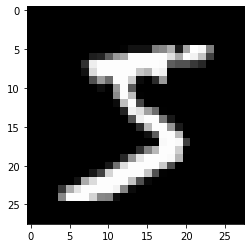

In [54]:
mean = 0.1307
std = 0.3081
n_strong = 3
m_strong = 5

n_weak = 1
m_weak = 3

fix_match_augmentation = TransformFixImage(
                                           mean=mean,
                                           std=std,
                                           n_strong=n_strong,
                                           m_strong=m_strong,
                                           n_weak=n_weak,
                                           m_weak=m_weak,
                                         )

train_loader_org = torchvision.datasets.MNIST(root ='./data',
                                        download=True,
                                        transform=transforms.Compose(
        [transforms.ToTensor()]
    ))
images, labels = next(iter(train_loader_org))
plt.imshow(images[0].reshape(28,28), cmap="gray")


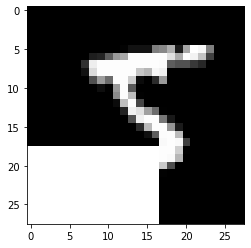

In [55]:
train_loader = torchvision.datasets.MNIST(root ='./data',
                                        download=True,
                                        transform=transforms.Compose(
        [transforms.ToTensor(), fix_match_augmentation ]
    ))
(images_w, images_s), labels = next(iter(train_loader))
plt.imshow(images_s[0].reshape(28,28), cmap="gray")

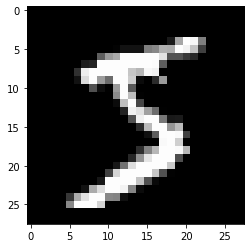

In [56]:
plt.imshow(images_w[0].reshape(28,28), cmap="gray")

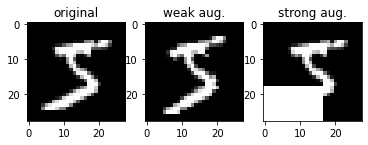

In [66]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(images[0],cmap='gray')
axarr[0].set_title("original",)
axarr[1].imshow(images_w[0], cmap='gray')
axarr[1].set_title("weak aug.")
axarr[2].imshow(images_s[0], cmap='gray')
axarr[2].set_title("strong aug.")
plt.savefig('tessstttyyy.png', dpi=100)

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


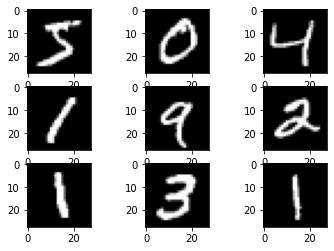

In [43]:
# example of loading the mnist dataset
from keras.datasets import mnist
from matplotlib import pyplot
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()




#### Test get_subsamples_sizes

In [ ]:
# print(get_subsamples_sizes(dataset='mr', phase='tuning'))
# print()
# print(get_subsamples_sizes(dataset='mr', phase='run'))
# print()
# print(get_subsamples_sizes(dataset='mr', phase='run_labeled_unlabeled_addition_1'))
# print()
# print(get_subsamples_sizes(dataset='mr', phase='run_labeled_unlabeled_addition_2'))
# print()
# print(get_subsamples_sizes(dataset='mr', phase='run_unlabeled_addition_1'))
# print()
# print(get_subsamples_sizes(dataset='mr', phase='run_unlabeled_addition_2'))
# print()

dataset = 'MR'
print(get_subsamples_sizes(dataset=dataset, phase='tuning_0'))
print(get_subsamples_sizes(dataset=dataset, phase='tuning_1'))
print(get_subsamples_sizes(dataset=dataset, phase='tuning_2'))
print(get_subsamples_sizes(dataset=dataset, phase='run'))
print(get_subsamples_sizes(dataset=dataset, phase='run_labeled_unlabeled_addition_1'))
print(get_subsamples_sizes(dataset=dataset, phase='run_labeled_unlabeled_addition_2'))
print(get_subsamples_sizes(dataset=dataset, phase='run_unlabeled_addition_1'))
print(get_subsamples_sizes(dataset=dataset, phase='run_unlabeled_addition_2'))

#### Test conduct single experiment

##### Hyperparameters sanity check

In [ ]:
hparams

{'dataset': 'IMDB',
 'dataset_path': 'gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv',
 'dropout': 0.1,
 'emb_mean': 0.001960038,
 'emb_std': 0.0732493,
 'embed_size': 300,
 'embeder_type': 'fastText.bin',
 'epoch_over_higher_ratio': True,
 'filter_sizes': '1,2,3,5',
 'l_batch_size': 32,
 'loss_function': 'CrossEntropyLoss',
 'lr': 0.001,
 'max_features': 45000,
 'max_steps': 200,
 'maxlen': 300,
 'model_arch': 'ConvolutionWithEmbeddingLayer',
 'n_labeled': 1600,
 'num_classes': 2,
 'num_filters': 32,
 'oov_token': '######',
 'optimizer_type': 'Adam',
 'save_best_model': True,
 'scheduler_type': 'None',
 'seed': 42,
 'test_batch_size': 16,
 'test_run': True,
 'train_l_size': 200,
 'train_test_split': 0.1,
 'train_unl_size': 400,
 'trainable_embeddings': False,
 'training_method': 'Supervised',
 'unl_batch_size': 32,
 'val_batch_size': 16,
 'val_size': 40}

##### Run

In [ ]:
method = hparams['training_method']
dataset = hparams['dataset']
project_name = f'{method}_{dataset}' # !!
hparams['project_name'] = project_name 
hparams['trail'] = str(0)
run_experiment(hparams,
               train_df=train_df,
               test_df=test_df,
               disable_validation=False,
               disable_testing=True)

dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: Supervised
l_batch_size: 32
unl_batch_size: 32
optimizer_type: Adam
lr: 0.001
dropout: 0.1
scheduler_type: None
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 42
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 200
train_unl_size: 400
val_size: 40
loss_function: CrossEntropyLoss
test_run: True
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 200
project_name: Supervised_IMDB
trail: 0
disable_validation: False
disable_testing: True


Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 6647 to 1970
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 46618 to 28070
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 40
real_labeled_size: 200
real_unlabeled_size: 400
labeled_to_batch_ratio:  6
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  200
Scheduler was not specified!



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

You are using LearningRateLogger callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.



ValueError: ignored

## Conduct Series of Experiment

### Tuning + Training

#### Check and initialize parameters

In [ ]:
hparams['test_run'] = False
trail = int(round(time.time() * 1000))
print(dataset)
print(training_method)
print(hparams)
print(trail)

IMDB
PseudoLabelling
{'dataset': 'IMDB', 'train_test_split': 0.1, 'num_classes': 2, 'dataset_path': 'gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv', 'maxlen': 300, 'training_method': 'PseudoLabelling', 'T1': 3000, 'af': 1, 'alpha_scheduler_interval': 'step', 'l_batch_size': 32, 'unl_batch_size': 32, 'dropout': 0.1, 'optimizer_type': 'Adam', 'lr': 1e-05, 'scheduler_type': 'StepLR', 'opt_scheduler_interval': 'epoch', 'decay_step_size': 40, 'decay_step': 400, 'decay_gamma': 0.5, 'max_epochs': 3, 'min_epochs': 1, 'model_arch': 'ConvolutionWithEmbeddingLayer', 'embeder_type': 'fastText.bin', 'max_features': 45000, 'oov_token': '######', 'filter_sizes': '1,2,3,5', 'num_filters': 32, 'embed_size': 300, 'trainable_embeddings': False, 'emb_mean': 0.001960038, 'emb_std': 0.0732493, 'seed': 42, 'val_batch_size': 16, 'test_batch_size': 16, 'n_labeled': 1600, 'train_l_size': 200, 'train_unl_size': 400, 'val_size': 40, 'loss_function': 'CrossEntropyLoss', 'test_run': 

##### Tuning to **v0**

In [ ]:
# first test - conduct single experiment then start tuning here
change_hparams_dict = {
                  'l_batch_size': 64,
                  'unl_batch_size': 256, # mu = 7
                  
                  'xi':1e-6,
                  'eps':3, 
                  'K':1, 
                  'alpha':1,

                  'dropout': 0.1, 

                  'optimizer_type': 'Adam',
                  'lr': 2e-05,
                  'scheduler_type': 'StepLR',
                  'opt_scheduler_interval': 'step',
                  'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  'decay_step_size': 100, # period of learning rate decay

                  'decay_step': 20, # when to lunch scheduler
                  'max_steps': 300,
                       }

hparams['trail'] = 't' + str(trail)
project_name_0 = run_phase_of_experiment(
                        training_method=training_method,
                        dataset_name=dataset,
                        phase='tuning_0',
                        hparams=hparams,
                        train_df=train_df,
                        test_df=test_df,
                        change_hparams_dict=change_hparams_dict,
                        disable_testing=True,
                        disable_validation=False,
                        )
trail += 1

dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.1
optimizer_type: Adam
lr: 0.001
scheduler_type: None
opt_scheduler_interval: step
decay_step_size: 2
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 0
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 160
train_unl_size: 399
val_size: 39
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
stop_training_at_step: None
project_name: PseudoLabelling_IMDB_v39
trail: t1598541941079
disable_v

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 22252 to 10807
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29420 to 45438
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 38
real_labeled_size: 160
real_unlabeled_size: 399
labeled_to_batch_ratio:  5
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37
Scheduler was not specified!



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

You are using LearningRateLogger callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.3819444444444445 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.3958333333333333 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.34027777777777785 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.3194444444444445 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.1
optimizer_type: Adam
lr: 0.001
scheduler_type: None
opt_scheduler_interval: step
decay_step_size: 2
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 1
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 160
train_unl_size: 399
val_size: 39
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
stop_training_at_step: None
project_name: PseudoLabelling_IMDB_v39
trail: t1598541941079
disable_v

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 22252 to 10807
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29420 to 45438
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 38
real_labeled_size: 160
real_unlabeled_size: 399
labeled_to_batch_ratio:  5
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37
Scheduler was not specified!



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

You are using LearningRateLogger callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5347222222222222 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5555555555555556 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.3958333333333333 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4166666666666667 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4583333333333333 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.1
optimizer_type: Adam
lr: 0.001
scheduler_type: None
opt_scheduler_interval: step
decay_step_size: 2
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 2
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 160
train_unl_size: 399
val_size: 39
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
stop_training_at_step: None
project_name: PseudoLabelling_IMDB_v39
trail: t1598541941079
disable_v

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 22252 to 10807
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29420 to 45438
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 38
real_labeled_size: 160
real_unlabeled_size: 399
labeled_to_batch_ratio:  5
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37
Scheduler was not specified!



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

You are using LearningRateLogger callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.513888888888889 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5208333333333334 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.46527777777777785 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.38888888888888884 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.3680555555555555 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4444444444444445 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.42361111111111116 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.40277777777777785 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.3819444444444445 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.36111111111111116 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


##### Tuning to **v1**

In [ ]:
change_hparams_dict = {
                  'l_batch_size': 64,
                  'unl_batch_size': 256, # mu = 7
                  
                  'xi':1e-6,
                  'eps':3, 
                  'K':1, 
                  'alpha':1,

                  'dropout': 0.2, 

                  'optimizer_type': 'Adam',
                  'lr': 2e-05,
                  'scheduler_type': 'StepLR',
                  'opt_scheduler_interval': 'step',
                  'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  'decay_step_size': 75, # period of learning rate decay

                  'decay_step': 20, # when to lunch scheduler
                  'max_steps': 300,
                       }

hparams['trail'] = 't' + str(trail)
project_name_1 = run_phase_of_experiment(
                        training_method=training_method,
                        dataset_name=dataset,
                        phase='tuning_1',
                        hparams=hparams,
                        train_df=train_df,
                         test_df=test_df,
                        change_hparams_dict=change_hparams_dict,
                        disable_testing=True,
                        disable_validation=False,
                        )
trail += 1

dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.2
optimizer_type: Adam
lr: 0.001
scheduler_type: StepLR
opt_scheduler_interval: step
decay_step_size: 200
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 0
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 140
train_unl_size: 399
val_size: 59
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
stop_training_at_step: None
project_name: PseudoLabelling_IMDB_v59
trail: t1598541941080
disab

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 22252 to 10807
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29420 to 45438
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 58
real_labeled_size: 140
real_unlabeled_size: 399
labeled_to_batch_ratio:  4
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.396875 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.415625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.421875 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.40625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.390625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.43125 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.365625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.35 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}
requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 474, 'content': ["ERROR 2020-08-27T16:04:00.281170 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete'

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/ibvqrmri/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/ibvqrmri/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 1844, 'content': ["ERROR 2020-08-27T16:04:00.280869 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}\n", 'ERROR 2020-08-27T16:04:00.913325 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream. args: (\'https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 2306, 'content': ["ERROR 2020-08-27T16:04:00.280729 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}\n", 'ERROR 2020-08-27T16:04:00.913248 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream. args: (\'https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 2306, 'content': ["ERROR 2020-08-27T16:04:00.280729 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}\n", 'ERROR 2020-08-27T16:04:00.913248 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream. args: (\'https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 2306, 'content': ["ERROR 2020-08-27T16:04:00.280729 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}\n", 'ERROR 2020-08-27T16:04:00.913248 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream. args: (\'https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2hvwqriu/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 2306, 'content': ["ERROR 2020-08-27T16:04:00.280729 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream. args: ('https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/2xa6745k/file_stream',), kwargs: {'json': {'complete': False, 'failed': False}}\n", 'ERROR 2020-08-27T16:04:00.913248 requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file_stream. args: (\'https://api.wandb.ai/files/mifi/PseudoLabelling_IMDB_v39/68gs2ud8/file


Training done


500 response executing GraphQL.
{"error":"driver: bad connection"}



500 response executing GraphQL.
{"error":"driver: bad connection"}

500 response executing GraphQL.
{"error":"driver: bad connection"}

Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.6/http/client.py", line 1356, in getresponse
    response.begin()
  File "/usr/lib/python3.6/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.6/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
 

dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.2
optimizer_type: Adam
lr: 0.001
scheduler_type: StepLR
opt_scheduler_interval: step
decay_step_size: 200
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 1
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 140
train_unl_size: 399
val_size: 59
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
stop_training_at_step: None
project_name: PseudoLabelling_IMDB_v59
trail: t1598541941080
disab

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 22252 to 10807
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29420 to 45438
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 58
real_labeled_size: 140
real_unlabeled_size: 399
labeled_to_batch_ratio:  4
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.534375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.55 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.471875 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.446875 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.43125 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.453125 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.46875 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.484375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.2
optimizer_type: Adam
lr: 0.001
scheduler_type: StepLR
opt_scheduler_interval: step
decay_step_size: 200
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 2
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 140
train_unl_size: 399
val_size: 59
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
stop_training_at_step: None
project_name: PseudoLabelling_IMDB_v59
trail: t1598541941080
disab

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 22252 to 10807
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29420 to 45438
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 58
real_labeled_size: 140
real_unlabeled_size: 399
labeled_to_batch_ratio:  4
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.525 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.515625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.46875 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.44375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.428125 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.459375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


##### Tuning to **v2**

In [ ]:
change_hparams_dict = {
                  'l_batch_size': 64,
                  'unl_batch_size': 256, # mu = 7
                  
                  'xi':1e-6,
                  'eps':3, 
                  'K':1, 
                  'alpha':1,

                  'dropout': 0.25, 

                  'optimizer_type': 'Adam',
                  'lr': 2e-05,
                  'scheduler_type': 'StepLR',
                  'opt_scheduler_interval': 'step',
                  'decay_gamma': 0.5, # multiplicative factor of learning rate decay. Default: 0.1.
                  'decay_step_size': 80, # period of learning rate decay

                  'decay_step': 20, # when to lunch scheduler
                  'max_steps': 300,
                       }

hparams['trail'] = 't' + str(trail)
project_name_2 = run_phase_of_experiment(
                        training_method=training_method,
                        dataset_name=dataset,
                        phase='tuning_2',
                        hparams=hparams,
                        train_df=train_df,
                        test_df=test_df,
                        change_hparams_dict=change_hparams_dict,
                        disable_testing=True,
                        disable_validation=False,
                        )
trail += 1

dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.1
optimizer_type: Adam
lr: 0.001
scheduler_type: StepLR
opt_scheduler_interval: step
decay_step_size: 250
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 0
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 100
train_unl_size: 399
val_size: 99
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
trail: t1598546205220
phase: tuning_2
project_name: PseudoLabelling_IMDB_v99
stop_training_at_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 28733 to 17815
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29616 to 22079
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 98
real_labeled_size: 100
real_unlabeled_size: 399
labeled_to_batch_ratio:  3
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5357142857142857 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5982142857142857 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5803571428571429 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5625 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4642857142857143 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.44642857142857145 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4732142857142857 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.38392857142857145 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.39285714285714285 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4107142857142857 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4017857142857143 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.1
optimizer_type: Adam
lr: 0.001
scheduler_type: StepLR
opt_scheduler_interval: step
decay_step_size: 250
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 1
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 100
train_unl_size: 399
val_size: 99
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
trail: t1598546205220
phase: tuning_2
project_name: PseudoLabelling_IMDB_v99
stop_training_at_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 28733 to 17815
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29616 to 22079
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 98
real_labeled_size: 100
real_unlabeled_size: 399
labeled_to_batch_ratio:  3
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5089285714285714 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4642857142857143 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4375 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.41964285714285715 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4017857142857143 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.38392857142857145 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.39285714285714285 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4107142857142857 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


dataset: IMDB
train_test_split: 0.1
num_classes: 2
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
maxlen: 300
training_method: PseudoLabelling
T1: 1000
af: 1
alpha_scheduler_interval: step
l_batch_size: 32
unl_batch_size: 32
dropout: 0.1
optimizer_type: Adam
lr: 0.001
scheduler_type: StepLR
opt_scheduler_interval: step
decay_step_size: 250
decay_step: 1
decay_gamma: 0.5
max_epochs: 3
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
embeder_type: fastText.bin
max_features: 45000
oov_token: ######
filter_sizes: 1,2,3,5
num_filters: 32
embed_size: 300
trainable_embeddings: False
emb_mean: 0.001960038
emb_std: 0.0732493
seed: 2
val_batch_size: 16
test_batch_size: 16
n_labeled: 1600
train_l_size: 100
train_unl_size: 399
val_size: 99
loss_function: CrossEntropyLoss
test_run: False
save_best_model: True
epoch_over_higher_ratio: True
max_steps: 1000
trail: t1598546205220
phase: tuning_2
project_name: PseudoLabelling_IMDB_v99
stop_training_at_

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 28733 to 17815
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 29616 to 22079
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 98
real_labeled_size: 100
real_unlabeled_size: 399
labeled_to_batch_ratio:  3
unlabeled_to_batch_ratio:  12
epoch_over:  unlabeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.45535714285714285 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.4732142857142857 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.44642857142857145 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.48214285714285715 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.49107142857142855 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning:

The metric you returned 0.5089285714285714 must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_accuracy_error in validation_epoch_end()?



Saving latest checkpoint..



Training done


#### Only training - runninig scaling experiments (more labeled+unlabeled data, more unlabeled data)

In [ ]:
# dataset = 'IMDB'
dataset = 'MR'

methods = [
          #  'PseudoLabelling',
          #  'Supervised',
          #  'VAT',
           'FixMatch'
           ]

val_sizes = ['99', '59', '39']

phases = [
          
'run_labeled_unlabeled_addition_1',  
'run_labeled_unlabeled_addition_2'  
          

         ]

get_experiment_scores_on_test(
                              dataset=dataset,
                              methods=methods,
                              val_sizes=val_sizes,
                              phases=phases,
                             )

  0%|          | 0/1 [00:00<?, ?it/s]

method:  FixMatch
----------------------------------------------------------------



  0%|          | 0/2 [00:00<?, ?it/s]

val_size:  59
--------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:280: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



init_load
load_hparams from:  FixMatch_IMDB_v59




  0%|          | 0/4 [00:00<?, ?it/s]

phase:  run_labeled_unlabeled_addition_1
------------------------------------------------------------


K: 1
T1: 3000
af: 1
alpha: 1
alpha_scheduler_interval: step
augmentation_type: WS
dataset: IMDB
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
decay_gamma: 0.5
decay_step: 20
decay_step_size: 80
disable_testing: False
disable_validation: True
dropout: 0.1
emb_mean: 0.001960038
emb_std: 0.0732493
embed_size: 300
embeder_type: fastText.bin
epoch_over: labeled_train_dataset
epoch_over_higher_ratio: True
eps: 3
filter_sizes: 1,2,3,5
l_batch_size: 32
lambda_u: 0.1
loss_function: CrossEntropyLoss
lr: 0.03
max_epochs: 3
max_features: 45000
max_steps: 500
maxlen: 300
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
momentum: 0.9
mu: 7
n_labeled: 1600
n_weak: 1
nesterov: False
num_classes: 2
num_cycles: 0.4375
num_filters: 32
oov_token: ######
opt_scheduler_interval: step
optimizer_type: SGD
phase: run_labeled_unlabeled_addition_1
project_name: IMDB_v0
real_labeled_size: 140
real_unlabeled_size: 399
real_val_size: 58
save_best_model: True
sche

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 396
real_unlabeled_size: 799
labeled_to_batch_ratio:  12
unlabeled_to_batch_ratio:  3
epoch_over:  labeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

Saving latest checkpoint..



<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 396
real_unlabeled_size: 799
labeled_to_batch_ratio:  12
unlabeled_to_batch_ratio:  3
epoch_over:  labeled_train_dataset
total_iterations:  37


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_error': 0.3605769230769231,
 'test_f1_error': 0.3605769230769231,
 'test_loss': 0.6489766,
 'test_max_confident': 0.8441862,
 'test_mean_confident': 0.6311046,
 'test_min_confident': 0.5114698,
 'test_precision_error': 0.3605769230769231,
 'test_recall_error': 0.3605769230769231,
 'test_std_confident': 0.099983215}
--------------------------------------------------------------------------------



K: 1
T1: 3000
af: 1
alpha: 1
alpha_scheduler_interval: step
augmentation_type: WS
dataset: IMDB
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
decay_gamma: 0.5
decay_step: 20
decay_step_size: 80
disable_testing: False
disable_validation: True
dropout: 0.1
emb_mean: 0.001960038
emb_std: 0.0732493
embed_size: 300
embeder_type: fastText.bin
epoch_over: labeled_train_dataset
epoch_over_higher_ratio: True
eps: 3
filter_sizes: 1,2,3,5
l_batch_size: 32
lambda_u: 0.1
loss_function: CrossEntropyLoss
lr: 0.03
max_epochs: 3
max_features: 45000
max_steps: 500
maxlen: 300
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
momentum: 0.9
mu: 7
n_labeled: 1600
n_weak: 1
nesterov: False
num_classes: 2
num_cycles: 0.4375
num_filters: 32
oov_token: ######
opt_scheduler_interval: step
optimizer_type: SGD
phase: run_labeled_unlabeled_addition_1
project_name: IMDB_v0
real_labeled_size: 140
real_unlabeled_size: 399
real_val_size: 58
save_best_model: True
sche

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 396
real_unlabeled_size: 799
labeled_to_batch_ratio:  12
unlabeled_to_batch_ratio:  3
epoch_over:  labeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

Saving latest checkpoint..



<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 396
real_unlabeled_size: 799
labeled_to_batch_ratio:  12
unlabeled_to_batch_ratio:  3
epoch_over:  labeled_train_dataset
total_iterations:  37


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_error': 0.3557692307692308,
 'test_f1_error': 0.3557692307692308,
 'test_loss': 0.6246112,
 'test_max_confident': 0.8084274,
 'test_mean_confident': 0.6095699,
 'test_min_confident': 0.5099422,
 'test_precision_error': 0.3557692307692308,
 'test_recall_error': 0.3557692307692308,
 'test_std_confident': 0.08581923}
--------------------------------------------------------------------------------



K: 1
T1: 3000
af: 1
alpha: 1
alpha_scheduler_interval: step
augmentation_type: WS
dataset: IMDB
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
decay_gamma: 0.5
decay_step: 20
decay_step_size: 80
disable_testing: False
disable_validation: True
dropout: 0.1
emb_mean: 0.001960038
emb_std: 0.0732493
embed_size: 300
embeder_type: fastText.bin
epoch_over: labeled_train_dataset
epoch_over_higher_ratio: True
eps: 3
filter_sizes: 1,2,3,5
l_batch_size: 32
lambda_u: 0.1
loss_function: CrossEntropyLoss
lr: 0.03
max_epochs: 3
max_features: 45000
max_steps: 500
maxlen: 300
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
momentum: 0.9
mu: 7
n_labeled: 1600
n_weak: 1
nesterov: False
num_classes: 2
num_cycles: 0.4375
num_filters: 32
oov_token: ######
opt_scheduler_interval: step
optimizer_type: SGD
phase: run_labeled_unlabeled_addition_1
project_name: IMDB_v0
real_labeled_size: 140
real_unlabeled_size: 399
real_val_size: 58
save_best_model: True
sche

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 396
real_unlabeled_size: 799
labeled_to_batch_ratio:  12
unlabeled_to_batch_ratio:  3
epoch_over:  labeled_train_dataset
total_iterations:  37



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

Saving latest checkpoint..



<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 396
real_unlabeled_size: 799
labeled_to_batch_ratio:  12
unlabeled_to_batch_ratio:  3
epoch_over:  labeled_train_dataset
total_iterations:  37


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_error': 0.3942307692307692,
 'test_f1_error': 0.3942307692307692,
 'test_loss': 0.6746243,
 'test_max_confident': 0.82879025,
 'test_mean_confident': 0.6116546,
 'test_min_confident': 0.5086402,
 'test_precision_error': 0.3942307692307692,
 'test_recall_error': 0.3942307692307692,
 'test_std_confident': 0.09303884}
--------------------------------------------------------------------------------

end phase:  run_labeled_unlabeled_addition_1
------------------------------------------------------------




 25%|██▌       | 1/4 [47:53<2:23:40, 2873.48s/it]

phase:  run_labeled_unlabeled_addition_2
------------------------------------------------------------


K: 1
T1: 3000
af: 1
alpha: 1
alpha_scheduler_interval: step
augmentation_type: WS
dataset: IMDB
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
decay_gamma: 0.5
decay_step: 20
decay_step_size: 80
disable_testing: False
disable_validation: True
dropout: 0.1
emb_mean: 0.001960038
emb_std: 0.0732493
embed_size: 300
embeder_type: fastText.bin
epoch_over: labeled_train_dataset
epoch_over_higher_ratio: True
eps: 3
filter_sizes: 1,2,3,5
l_batch_size: 32
lambda_u: 0.1
loss_function: CrossEntropyLoss
lr: 0.03
max_epochs: 3
max_features: 45000
max_steps: 500
maxlen: 300
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
momentum: 0.9
mu: 7
n_labeled: 1600
n_weak: 1
nesterov: False
num_classes: 2
num_cycles: 0.4375
num_filters: 32
oov_token: ######
opt_scheduler_interval: step
optimizer_type: SGD
phase: run_labeled_unlabeled_addition_2
project_name: IMDB_v0
real_labeled_size: 140
real_unlabeled_size: 399
real_val_size: 58
save_best_model: True
sche

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 598
real_unlabeled_size: 1201
labeled_to_batch_ratio:  18
unlabeled_to_batch_ratio:  5
epoch_over:  labeled_train_dataset
total_iterations:  56



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

Saving latest checkpoint..



<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 598
real_unlabeled_size: 1201
labeled_to_batch_ratio:  18
unlabeled_to_batch_ratio:  5
epoch_over:  labeled_train_dataset
total_iterations:  56


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_error': 0.375,
 'test_f1_error': 0.375,
 'test_loss': 0.6390779,
 'test_max_confident': 0.7941827,
 'test_mean_confident': 0.6075062,
 'test_min_confident': 0.5168065,
 'test_precision_error': 0.375,
 'test_recall_error': 0.375,
 'test_std_confident': 0.08012591}
--------------------------------------------------------------------------------



K: 1
T1: 3000
af: 1
alpha: 1
alpha_scheduler_interval: step
augmentation_type: WS
dataset: IMDB
dataset_path: gdrive/My Drive/praca_magisterska/pytorch_lightning/datasets/imdb_with_bt.csv
decay_gamma: 0.5
decay_step: 20
decay_step_size: 80
disable_testing: False
disable_validation: True
dropout: 0.1
emb_mean: 0.001960038
emb_std: 0.0732493
embed_size: 300
embeder_type: fastText.bin
epoch_over: labeled_train_dataset
epoch_over_higher_ratio: True
eps: 3
filter_sizes: 1,2,3,5
l_batch_size: 32
lambda_u: 0.1
loss_function: CrossEntropyLoss
lr: 0.03
max_epochs: 3
max_features: 45000
max_steps: 500
maxlen: 300
min_epochs: 1
model_arch: ConvolutionWithEmbeddingLayer
momentum: 0.9
mu: 7
n_labeled: 1600
n_weak: 1
nesterov: False
num_classes: 2
num_cycles: 0.4375
num_filters: 32
oov_token: ######
opt_scheduler_interval: step
optimizer_type: SGD
phase: run_labeled_unlabeled_addition_2
project_name: IMDB_v0
real_labeled_size: 140
real_unlabeled_size: 399
real_val_size: 58
save_best_model: True
sche

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 17728 to 44156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      45000 non-null  int64 
 1   Unnamed: 0.1    45000 non-null  int64 
 2   Unnamed: 0.1.1  45000 non-null  int64 
 3   text            45000 non-null  object
 4   label           45000 non-null  int64 
 5   paraphrases     45000 non-null  object
 6   len             45000 non-null  int64 
 7   diff            45000 non-null  int64 
 8   parahprases     45000 non-null  object
dtypes: int64(6), object(3)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 22526 to 48901
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      200 non-null    int64 
 1   Unnamed: 0.1    200 non-null    int64 
 2   Unnamed: 0.1.1  200 non-null    int64 
 3   text          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



real_val_size: 0
real_labeled_size: 598
real_unlabeled_size: 1201
labeled_to_batch_ratio:  18
unlabeled_to_batch_ratio:  5
epoch_over:  labeled_train_dataset
total_iterations:  56



  | Name      | Type             | Params
-----------------------------------------------
0 | loss_fct  | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13 M  
2 | convs1    | ModuleList       | 105 K 
3 | dropout   | Dropout          | 0     
4 | fc1       | Linear           | 258   


In [ ]:
dataset = 'IMDB'
# dataset = 'MR'

methods = [
          #  'PseudoLabelling',
          #  'Supervised',
          #  'VAT',
           'FixMatch'
           ]

val_sizes = ['39']

phases = [
          'run',
          'run_labeled_unlabeled_addition_1',
          'run_labeled_unlabeled_addition_2',
          'run_unlabeled_addition_1',
          'run_unlabeled_addition_2',
         ]

get_experiment_scores_on_test(
                              dataset=dataset,
                              methods=methods,
                              val_sizes=val_sizes,
                              phases=phases,
                             )

In [ ]:
dataset = 'IMDB'
# dataset = 'MR'

methods = [
          #  'PseudoLabelling',
          #  'Supervised',
          'VAT',
          #  'FixMatch'
           ]

val_sizes = ['59']

phases = [
          'run_unlabeled_addition_1',
          'run_unlabeled_addition_2',
         ]

get_experiment_scores_on_test(
                              dataset=dataset,
                              methods=methods,
                              val_sizes=val_sizes,
                              phases=phases,
                             )

In [ ]:
dataset = 'IMDB'
# dataset = 'MR'

methods = [
          #  'PseudoLabelling',
          #  'Supervised',
          'VAT',
          #  'FixMatch'
           ]

val_sizes = ['39']

phases = [
          'run',
          'run_labeled_unlabeled_addition_1',
          'run_labeled_unlabeled_addition_2',
          'run_unlabeled_addition_1',
          'run_unlabeled_addition_2',
         ]

get_experiment_scores_on_test(
                              dataset=dataset,
                              methods=methods,
                              val_sizes=val_sizes,
                              phases=phases,
                             )